In [ ]:
import gc
import os
import pickle
from pathlib import Path
from types import SimpleNamespace

import numpy as np
import proplot as pplt
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from proplot.axes import Axes
from proplot.figure import Figure

from evaluation.fluctuation_analysis.anomaly_scores import AnomalyScores
from evaluation.fluctuation_analysis.utils import get_cached_anomaly_scores, \
    roc_metrics_for_threshold_with_normal, aoc_metrics_for_epoch_with_normal, get_cached_losses

plt.style.use('bmh')
plt.rcParams.update(
    {
        "text.usetex": True,
        'text.latex.preamble': r'\usepackage{amsfonts,amsmath}',
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
    }
)

plt.rcParams['axes.facecolor'] = '#f9f9f9'


In [2]:

TRAIN_COL   =   'blue'
VAL_COL     =   'orange'
THR_COL     =   'black'
DR_COL      =   'green'
FP_COL      =   'red'

TRAIN = {
    "color" : TRAIN_COL,
    "linestyle" : "-.",
    "linewidth" : 1.5,
}
VAL = {
    "color" : VAL_COL,
    "linestyle" : "-.",
    "linewidth" : 1.5,
}
THRESHOLD = {
    "color" : THR_COL,
    "linestyle" : "",
    "marker" : "x",
    "markersize" : 4,
}
DR = {
    "color" : DR_COL,
    "linestyle" : "--",
    "linewidth" : 0.8,
    "marker" : "*",
}
FP = {
    "color" : FP_COL,
    "linestyle" : "",
    "marker" : "o",
    "markersize" : 4,
}


In [3]:

scenario_short = {
    "CVE-2017-7529": "2017",
    "CVE-2014-0160": "2014",
    "CVE-2012-2122": "2012",
    "Bruteforce_CWE-307": "BF",
    "CWE-89-SQL-injection": "SQL",
    "SQL_Injection_CWE-89": "SQL",
    "PHP_CWE-434": "PHP",
    "CVE-2018-3760": "2018",
    "CVE-2019-5418": "2019",
}

dataset_short = {
    "LID-DS-2019": "19",
    "LID-DS-2021": "21",
}

BASE_PATH = "final"


ngs = {
    "train": r"$\mathbb{T}_\text{ALL}$",
    "val": r"$\mathbb{V}_\text{ALL}$",
    "after": r"$\mathbb{A}_\text{ALL}$",
    "before": r"$\mathbb{B}_\text{ALL}$",
    "normal": r"$\mathbb{N}_\text{ALL}$",
    "normal_rec": r"$\mathbb{N}_{\text{REC}_i}$",
    "after_rec": r"$\mathbb{A}_{\text{REC}_i}$",
    "before_rec": r"$\mathbb{B}_{\text{REC}_i}$",
}

In [4]:
configs = {
    ('AE', 'LID-DS-2019', 'CVE-2017-7529', 5, 0.5, False, True): 326,
    ('AE', 'LID-DS-2019', 'PHP_CWE-434', 5, 0.5, False, True): 56,
    ('TF', 'LID-DS-2019', 'CVE-2012-2122', 5, 16, 2, 2, 0.1, False): 146,
    ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 16, 16, 2, 2, 0.1, False): 221
}


In [13]:
for config, epoch in configs.items():
    ANOS_s = get_cached_anomaly_scores(config, base_path=BASE_PATH)
    picked = ANOS_s[epoch]
    ngram_sets_scores = {
        "train": picked.train,
        "val": picked.val,
        "after": picked.after_exploit,
        "before": picked.before_exploit,
        "normal": picked.normal,
        "threshold": picked.threshold,
        "epoch": epoch,
    }

    # save for config
    Path("final_plots/ngrams").mkdir(parents=True, exist_ok=True)
    with open(f"final_plots/ngrams/ngram_sets_{config[0]}_{config[2]}_{epoch}.pkl", "wb") as f:
        pickle.dump(ngram_sets_scores, f)



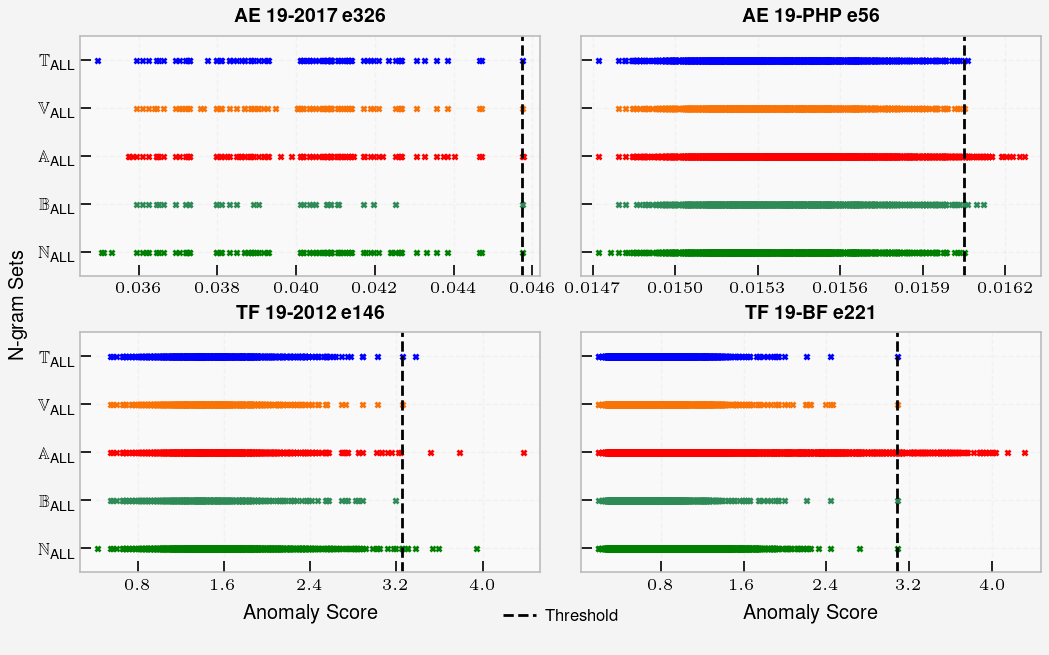

In [133]:
pplt.rc.update({'fontsize': 6})
axs: Axes
fig: Figure
fig, axs = pplt.subplots(
    nrows=2, 
    ncols=2, 
    sharex=False,
    refwidth=2.3, 
    refheight=1.2, 
    innerpad=0.5
)
for ax, (config, epoch) in zip(axs, configs.items()):
    ax: Axes
    pickle_path = f"final_plots/ngrams/ngram_sets_{config[0]}_{config[2]}_{epoch}.pkl"
    with open(pickle_path, "rb") as f:
        anos = pickle.load(f)
        anos = SimpleNamespace(**anos)
    marker_size = 1.8
    ax.plot(anos.normal, [0] * len(anos.normal), "x", color='green', markersize=marker_size)
    ax.plot(anos.before, [1] * len(anos.before), "x", color='seagreen', markersize=marker_size)
    ax.plot(anos.after, [2] * len(anos.after), "x", color='red', markersize=marker_size)
    ax.plot(anos.val, [3] * len(anos.val), "x", color='orange', markersize=marker_size)
    ax.plot(anos.train, [4] * len(anos.train), "x", color='blue', markersize=marker_size)
    thh = ax.axvline(x=anos.threshold, color='black', linestyle='--', linewidth=1)

    ax.set_title(
        label=f"\\textbf{{{config[0]} {dataset_short[config[1]]}-{scenario_short[config[2]]} e{epoch}}}",
        fontdict={"fontsize": 7, "fontweight": "bold"}
    )
    ax.set_xlabel("Anomaly Score")
    ax.set_ylabel("N-gram Sets")
    min_x = min(anos.normal + anos.before + anos.after + anos.val + anos.train)
    max_x = max(anos.normal + anos.before + anos.after + anos.val + anos.train)
    min_max_range = max_x - min_x
    offset = min_max_range * 0.04
    ax.set_xlim(min_x - offset, max_x + offset)
    ax.set_ylim(-0.5, 4.5)
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_yticklabels([ngs["normal"], ngs["before"], ngs["after"], ngs["val"], ngs["train"]])

axs[0, :].format(
    xlabel="",
)
axs.format(
    ytickminor=False,
)
fig.legend(
    [thh],
    ["Threshold"],
    loc="b",
    pad=-1,
    frame=False,
)

path = "final_plots/all_or_none_single_epochs.png"
fig.save(path, dpi=400)



In [134]:

configs = [
    ('AE', 'LID-DS-2019', 'CVE-2017-7529', 5, 0.5, False, True),
    ('AE', 'LID-DS-2019', 'PHP_CWE-434', 16, 0.5, False, True),
    ('TF', 'LID-DS-2019', 'CVE-2012-2122', 16, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 16, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2021', 'PHP_CWE-434', 5, 16, 2, 2, 0.1, False),
]


In [135]:
# cache only necessary scores
def cache_ano_scores():
    for config in configs:
        path = f"final_plots/anomaly_scores/{config[0]}_{config[1]}_{config[2]}_{config[3]}_{config[4]}_{config[5]}_{config[6]}_anos_scores_over_epochs.pkl"
        if os.path.exists(path):
            print("skip", config)
            continue
        gc.collect()
        ANOS_s = get_cached_anomaly_scores(config, base_path=BASE_PATH + "_exc_val")
        anos_over_epochs = []
        for _anos in ANOS_s.values():
            _anos: AnomalyScores
            dr, _, _, _ = roc_metrics_for_threshold_with_normal(_anos)
            anos_over_epochs.append(
                SimpleNamespace(
                    **{
                        "threshold": _anos.threshold,
                        "epoch": _anos.epoch,
                        "normal_exc_val": _anos.normal_exc_val,
                        "after_exploit_exc_val": _anos.after_exploit_exc_val,
                        "detected": sum(_anos.detected),
                        "false_positives": sum(_anos.false_positives),
                        "detected_rate": dr,
                    }
                )
            )

        with open(path, "wb") as f:
            pickle.dump(anos_over_epochs, f)


cache_ano_scores()

skip ('AE', 'LID-DS-2019', 'CVE-2017-7529', 5, 0.5, False, True)
skip ('AE', 'LID-DS-2019', 'PHP_CWE-434', 16, 0.5, False, True)
skip ('TF', 'LID-DS-2019', 'CVE-2012-2122', 16, 16, 2, 2, 0.1, False)
skip ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 16, 16, 2, 2, 0.1, False)
skip ('TF', 'LID-DS-2021', 'PHP_CWE-434', 5, 16, 2, 2, 0.1, False)


In [136]:
all_anos_over_epochs = {}


def load_ano_scores():
    for config in configs:
        path = f"final_plots/anomaly_scores/{config[0]}_{config[1]}_{config[2]}_{config[3]}_{config[4]}_{config[5]}_{config[6]}_anos_scores_over_epochs.pkl"
        with open(path, "rb") as f:
            all_anos_over_epochs[config] = pickle.load(f)


load_ano_scores()

In [137]:

plt.rcParams.update({"text.usetex": False, })


In [172]:

configs = [
    ('AE', 'LID-DS-2019', 'CVE-2017-7529', 5, 0.5, False, True),
    ('AE', 'LID-DS-2019', 'PHP_CWE-434', 16, 0.5, False, True),
    ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 16, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2021', 'PHP_CWE-434', 5, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2019', 'CVE-2012-2122', 16, 16, 2, 2, 0.1, False),
    # ('TF', 'LID-DS-2021', 'PHP_CWE-434', 5, 16, 2, 2, 0.1, True),
]


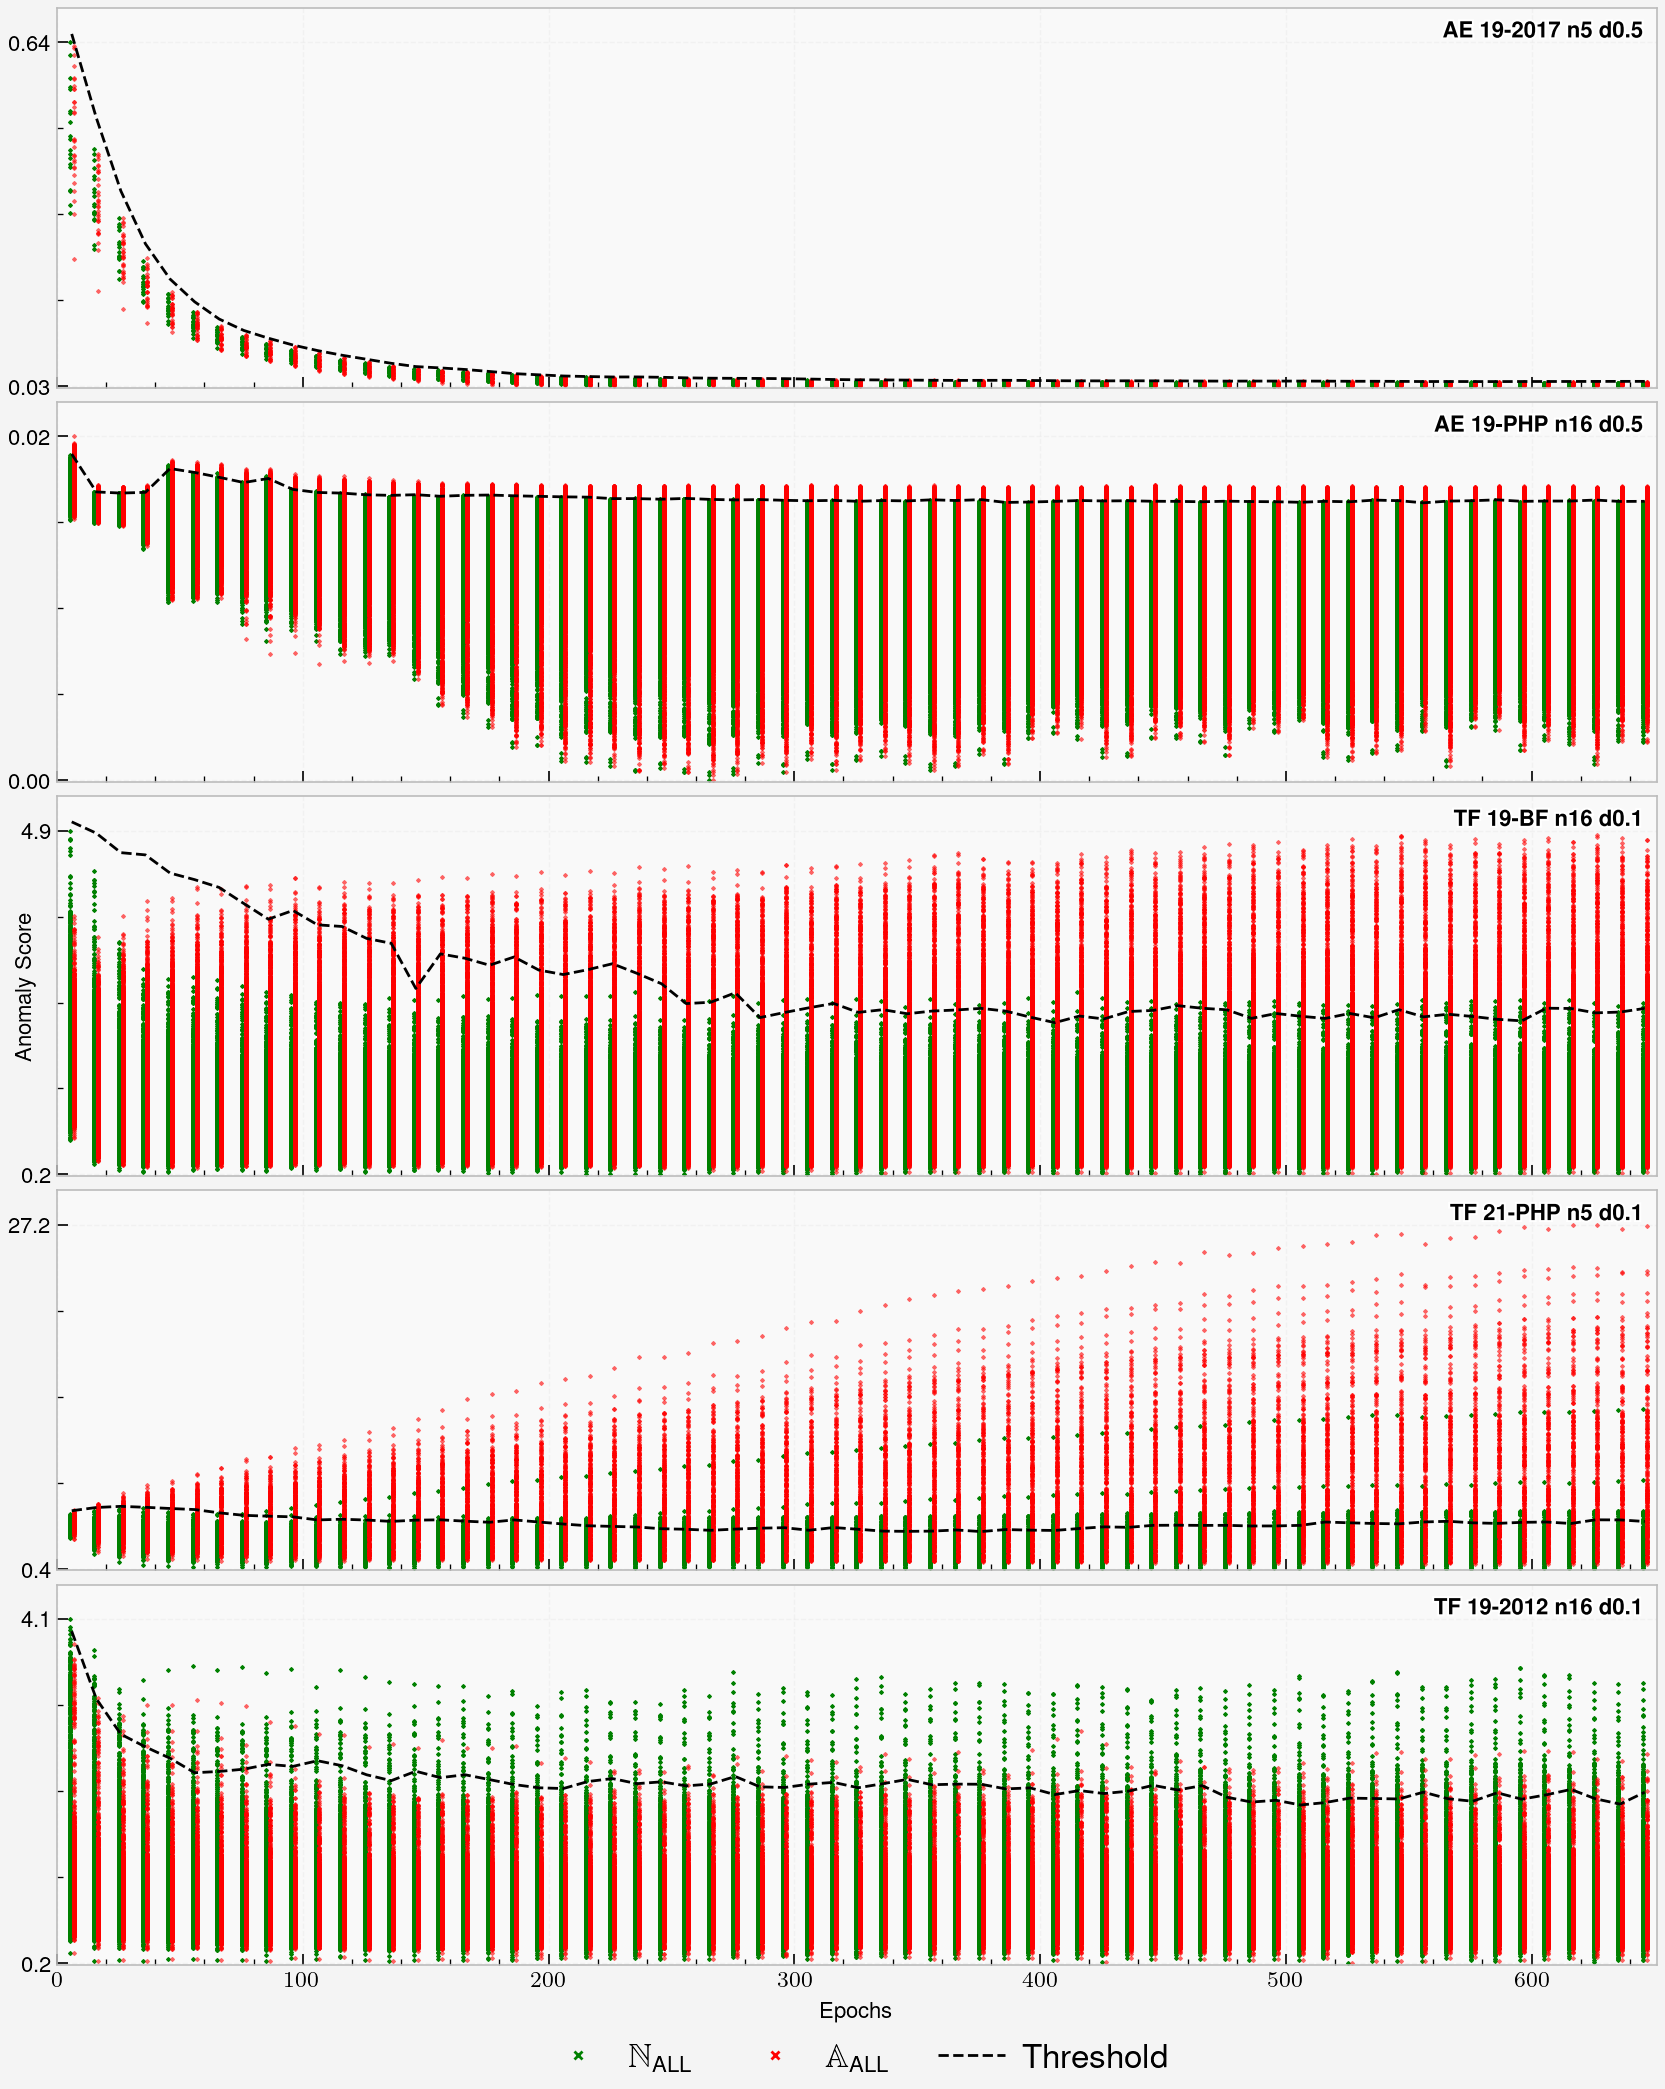

In [173]:
fig, axs = pplt.subplots(nrows=len(configs), ncols=1, sharex=True,sharey=True, refwidth=8, refheight=1.9, innerpad=0.2)
log_scale = True
marker_size = 1
for ax_d, config in zip(axs, configs):
    ax_d: Axes
    anos_s = all_anos_over_epochs[config][1:130:2]
    title = f" {config[0]} {dataset_short[config[1]]}-{scenario_short[config[2]]} n{config[3]} d{config[4] if config[0] == 'AE' else config[7]}"
    thresholds = [_anos.threshold for _anos in anos_s]
    epochs = [_anos.epoch for _anos in anos_s]

    max_ano_score = max([max(_anos.normal_exc_val + _anos.after_exploit_exc_val) for _anos in anos_s])
    min_ano_score = min([min(_anos.normal_exc_val + _anos.after_exploit_exc_val) for _anos in anos_s])
    for _anos in anos_s:
        ax_d.plot(
            [_anos.epoch - 0.8] * len(_anos.normal_exc_val),
            _anos.normal_exc_val,
            "x",
            color='green',
            label="normal",
            markersize=marker_size,
        )
        ax_d.plot(
            [_anos.epoch + 0.8] * len(_anos.after_exploit_exc_val),
            _anos.after_exploit_exc_val,
            "x",
            color='red',
            label="after exploit",
            alpha=0.6,
            markersize=marker_size,
        )
    

    ax_d.plot(epochs, thresholds, color='black', label='Threshold', markersize=1, linestyle='--', linewidth=1)
    ax_d.set_title(
        label=f"\\textbf{{{title}}}",
        fontdict={"fontsize": 8, "fontweight": "bold"},
    )

    min_max_range = max_ano_score - min_ano_score
    ax_d.get_yticks()
    ax_d.set_yticks([min_ano_score, max_ano_score])
    ax_d.set_ylim(min_ano_score - min_max_range * 0.005, max_ano_score + min_max_range * 0.1)
    ax_d.set_xlim(0, max(epochs) + 5)
    ax_d.set_xticks(range(0, max(epochs) + 1, 100))
    ax_d.tick_params(axis='y', labelsize=8)
    ax_d.tick_params(axis='x', labelsize=8)
    if max_ano_score < 1:
        ax_d.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    else:
        ax_d.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

legend_entries = [
    ax_d.plot([], [], 'x', color='green', label=ngs['normal'], markersize=marker_size + 2)[0],
    ax_d.plot([], [], 'x', color='red', label=ngs["after"], markersize=marker_size + 2)[0],
    ax_d.plot([], [], color='black', label='Threshold', markersize=2, linestyle='--', linewidth=1)[0],
]

with pplt.rc.context({'legend.fontsize': 12}):
    fig.legend(
        handles=legend_entries,
        loc="b",
        frame=False,
        pad=3,
        # fontsize='large',
        fontsize=40,
    )

fig.format(
    xlabel="Epochs",
    ylabel="Anomaly Score",
    ylabelpad=-10,
    labelsize=8,
    titleloc="ur",
)

path = "final_plots/all_or_none_anomaly_scores_over_epochs.png"
fig.save(path, dpi=400)


In [170]:
configs = [
    ('AE', 'LID-DS-2019', 'CVE-2017-7529', 5, 0.5, False, True),
    ('AE', 'LID-DS-2019', 'CVE-2012-2122', 5, 0.5, False, True),
    ('AE', 'LID-DS-2019', 'PHP_CWE-434', 16, 0.5, False, True),
    ('AE', 'LID-DS-2019', 'SQL_Injection_CWE-89', 5, 0.5, False, True),
    ('AE', 'LID-DS-2019', 'CVE-2019-5418', 8, 0.5, False, True),
    ('AE', 'LID-DS-2021', 'PHP_CWE-434', 5, 0.5, False, True),
    ('TF', 'LID-DS-2019', 'CVE-2017-7529', 8, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2019', 'CVE-2012-2122', 8, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2019', 'CVE-2012-2122', 5, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2021', 'CVE-2012-2122', 5, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 16, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2021', 'PHP_CWE-434', 5, 16, 2, 2, 0.1, False),
]

In [11]:

all_detected_false_over_epochs = {}


In [12]:
# cache only necessary counts
def get_detected_false_coutes(conf):
    path = f"final_plots/detected/{conf[0]}_{conf[1]}_{conf[2]}_{conf[3]}_{conf[4]}_{conf[5]}_{conf[6]}_detected_false_counts.pkl"
    if os.path.exists(path):
        with open(path, "rb") as f:
            all_detected_false_over_epochs[conf] = pickle.load(f)
            return all_detected_false_over_epochs[conf]
    print("NOT cached ", conf)
    gc.collect()
    ANOS_s = get_cached_anomaly_scores(conf, base_path=BASE_PATH)
    detected_false_over_epochs = []
    for _anos in ANOS_s.values():
        _anos: AnomalyScores
        tpr_max, fpr_max, tp, fp = roc_metrics_for_threshold_with_normal(_anos)
        ths, tpr, fpr, roc_auc = aoc_metrics_for_epoch_with_normal(_anos)
        detected_false_over_epochs.append(
            SimpleNamespace(
                **{
                    "threshold": _anos.threshold,
                    "epoch": _anos.epoch,
                    "detected": sum(_anos.detected),
                    "false_positives": sum(_anos.false_positives),
                    "detected_rate": tpr_max,
                    "tpr_max": tpr_max,
                    "fpr_max": fpr_max,
                    "tp": tp,
                    "fp": fp,
                    "tp_max": tp,
                    "fp_max": fp,
                    "roc_auc": roc_auc,
                    "ths": ths,
                    "tpr": tpr,
                    "fpr": fpr,

                }
            )
        )

    with open(path, "wb") as f:
        pickle.dump(detected_false_over_epochs, f)
    all_detected_false_over_epochs[conf] = detected_false_over_epochs
    return detected_false_over_epochs


def cache_detected_false_counts():
    for _config in configs:
        get_detected_false_coutes(_config)


cache_detected_false_counts()

In [13]:


def load_detected_false_counts():
    for config in configs:
        path = f"final_plots/detected/{config[0]}_{config[1]}_{config[2]}_{config[3]}_{config[4]}_{config[5]}_{config[6]}_detected_false_counts.pkl"
        with open(path, "rb") as f:
            all_detected_false_over_epochs[config] = pickle.load(f)


load_detected_false_counts()


In [152]:

def plot_detected_false_positive_detection_rate(_configs, _path, ncols=3):
    nrows = len(_configs) // ncols
    fig, axs = pplt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, refwidth=2.5, refheight=2.5, innerpad=0.2 )
    marker_size = 1
    for _ax, config in zip(axs, _configs):
        _ax: Axes
        detected_false_over_epochs = all_detected_false_over_epochs[config]
        title = f"{config[0]} {dataset_short[config[1]]}-{scenario_short[config[2]]} n{config[3]} d{config[4] if config[0] == 'AE' else config[7]}"
        epochs = [_anos.epoch for _anos in detected_false_over_epochs]
        detected = [_anos.detected for _anos in detected_false_over_epochs]
        false_positives = [_anos.false_positives for _anos in detected_false_over_epochs]
        detection_rates = [_anos.detected_rate for _anos in detected_false_over_epochs]

        max_detected = max([_anos.detected for _anos in detected_false_over_epochs])
        max_false_positives = max([_anos.false_positives for _anos in detected_false_over_epochs])
        max_detected_false = max(max_detected, max_false_positives)

        _ax.plot(
            epochs,
            detected,
            color='green',
            label='detected',
            marker="x",
            markersize=marker_size,
            linestyle='-.',
            linewidth=0.5
        )
        _ax.scatter(epochs, false_positives, color='red', label='false positives', markersize=marker_size, marker='o')
        ax_dr = _ax.twinx()
        ax_dr.fill_between(epochs, detection_rates, color='grey', label='detection rate', alpha=0.4, step='post')
        ax_dr.set_ylim(0, 1)
        ax_dr.set_yticks([0, 1])
        # ax_dr.set_yticklabels(["0%", "100%"])

        _ax.set_title(
            label=title,
            fontdict={"fontsize": 10, "fontweight": "bold"},
        )

        # ax.set_ylim(0, max_detected_false + 0.1 * max_detected_false)
        _ax.set_xlim(0, max(epochs) + 5)
        _ax.set_xticks(range(0, max(epochs) + 1, 200))
        _ax.set_yticks([0, max_detected_false])
        _ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
        _ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

        if _ax.is_first_col():
            _ax.set_ylabel("TP-NG/ FP-NG")

        if _ax.is_last_col():
            ax_dr.set_ylabel("DR", size=10)
            ax_dr.format(ylabelpad=-2)

    legend_entries = [
        _ax.plot(
            [],
            [],
            color='green',
            label='TP-NG',
            marker="x",
            markersize=marker_size + 3,
            linestyle='--',
            linewidth=1
        )[0],
        _ax.scatter([], [], color='red', label='FP-NG', markersize=marker_size + 3, marker='o'),
        ax_dr.fill_between([], [], color='grey', label='DR', alpha=0.6, step='post'),
    ]
    axs.format(
        abc='A.',
        abcloc='ul',
        abcweight='bold',
    )
    with pplt.rc.context({'legend.fontsize': 12}):
        fig.legend(
            handles=legend_entries,
            loc="b",
            frame=False,
            fontsize=6,
            pad=1
        )

    fig.format(
        xlabel="Epochs",
        # ylabel="Detected / False Positives",
        labelsize=10,
        titleloc="ur",
        ylabelpad=-8,
    )
    axs[0:2,:].format(
          ylabelpad=-2,
    )

    fig.save(_path, dpi=400)



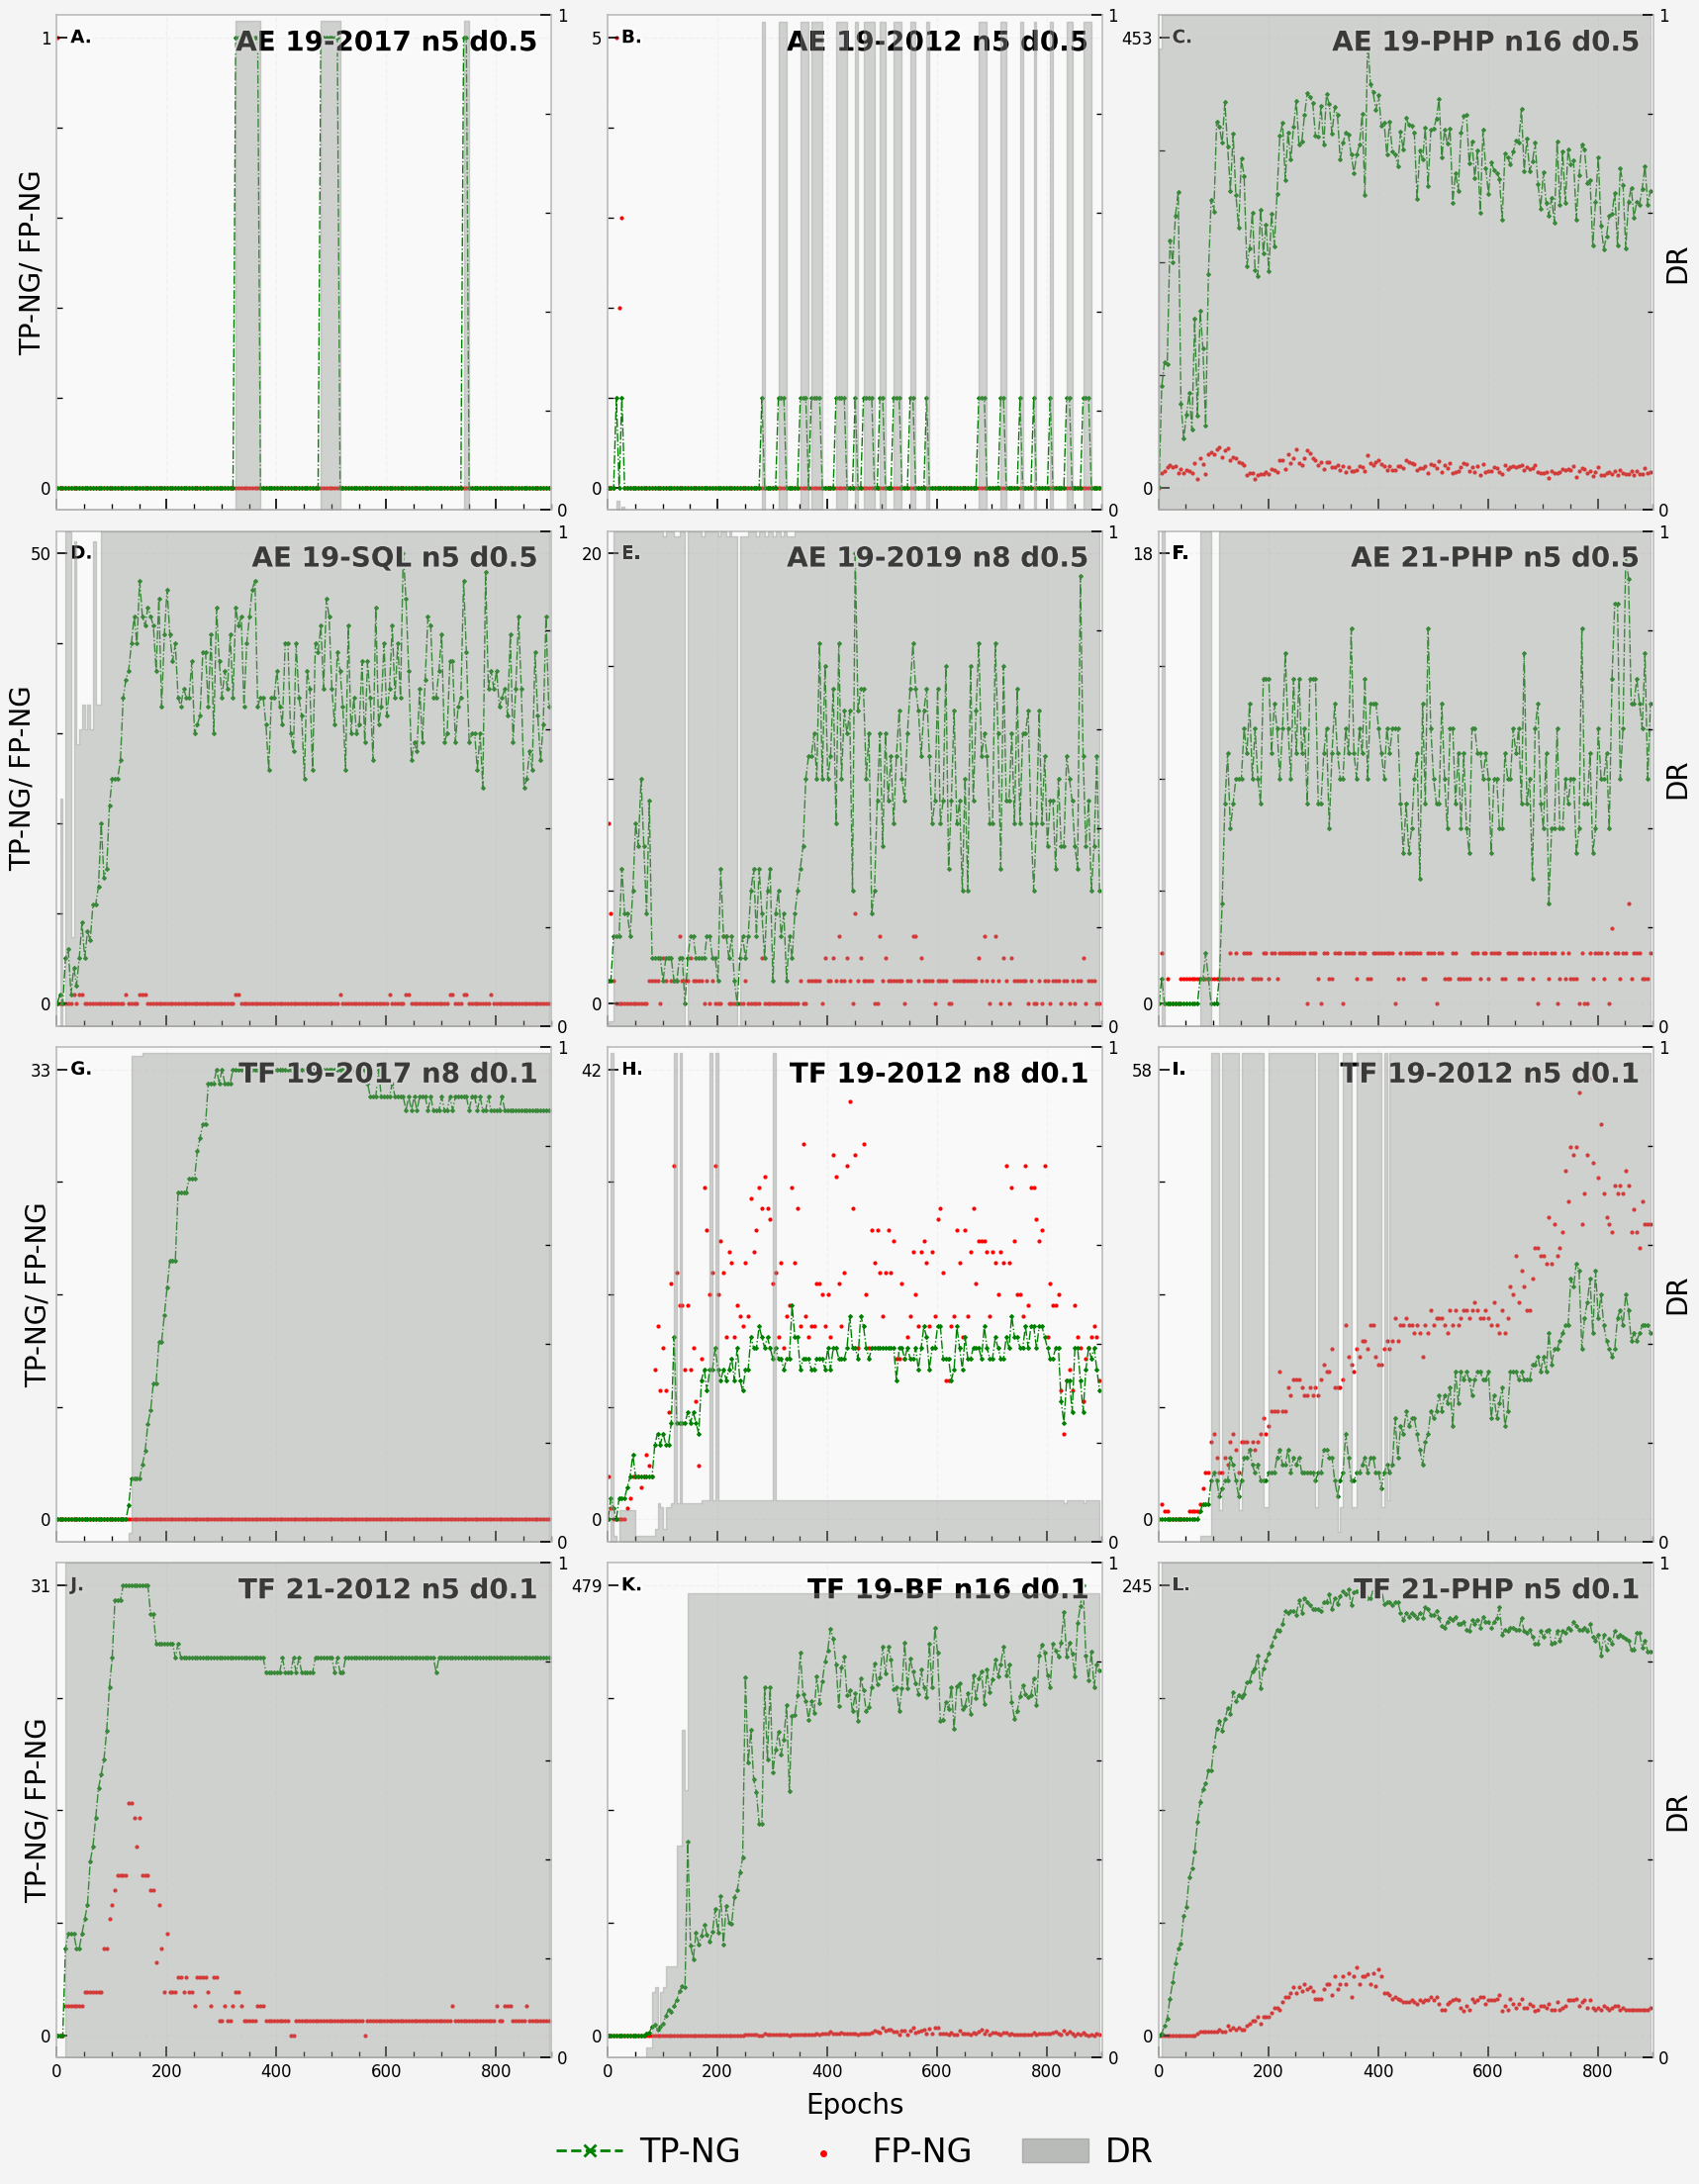

In [153]:

plt.rcParams.update({"text.usetex": False, })
path = "final_plots/all_or_none_detected_false_positives_over_epochs.png"

plot_detected_false_positive_detection_rate(configs, path)


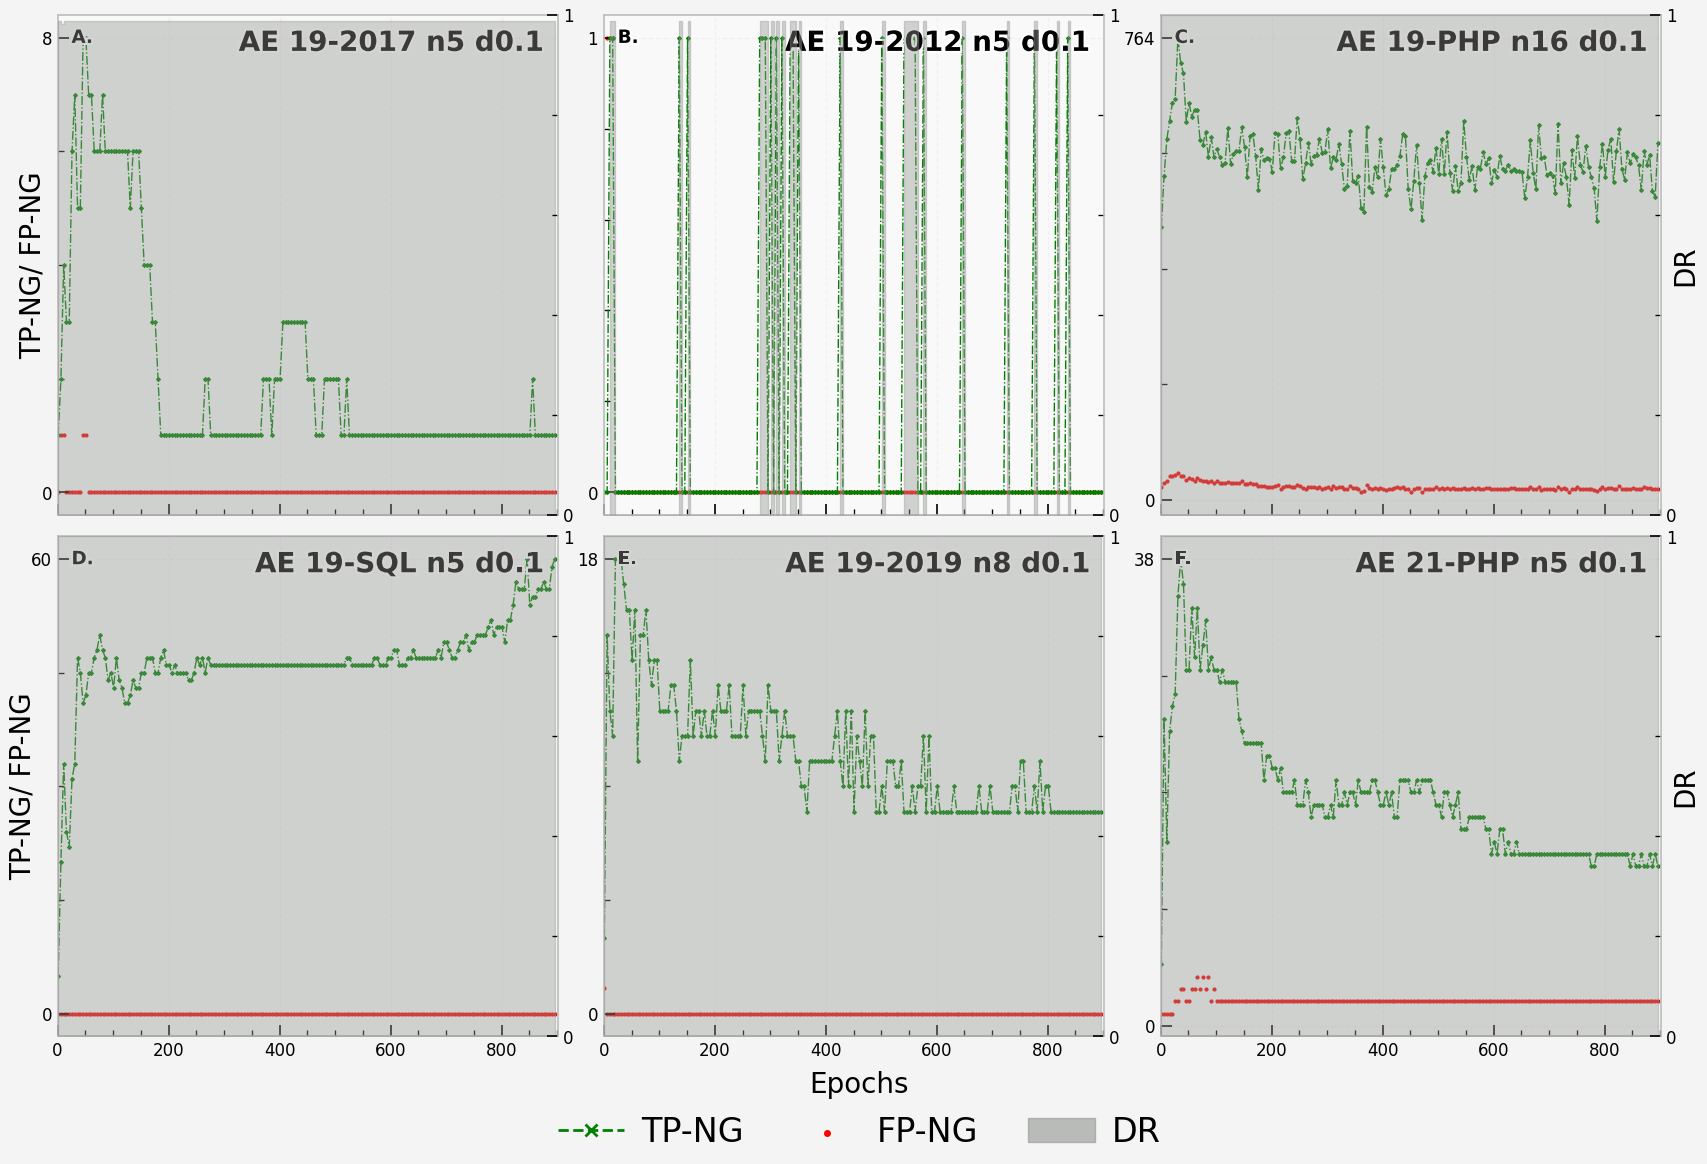

In [157]:

configs = [
    ('AE', 'LID-DS-2019', 'CVE-2017-7529', 5, 0.1, False, True),
    ('AE', 'LID-DS-2019', 'CVE-2012-2122', 5, 0.1, False, True),
    ('AE', 'LID-DS-2019', 'PHP_CWE-434', 16, 0.1, False, True),
    ('AE', 'LID-DS-2019', 'SQL_Injection_CWE-89', 5, 0.1, False, True),
    ('AE', 'LID-DS-2019', 'CVE-2019-5418', 8, 0.1, False, True),
    ('AE', 'LID-DS-2021', 'PHP_CWE-434', 5, 0.1, False, True),
]

plt.rcParams.update({"text.usetex": False, })
path = "final_plots/all_or_none_detected_false_positives_over_epochs_ae_dropout_all.png"

plot_detected_false_positive_detection_rate(configs, path, ncols=3)


In [10]:
configs = {
    ('AE', 'LID-DS-2019', 'CVE-2017-7529', 5, 0.5, False, True): 51,
    ('AE', 'LID-DS-2019', 'PHP_CWE-434', 16, 0.5, False, True): 471,
    ('TF', 'LID-DS-2019', 'CVE-2012-2122', 8, 16, 2, 2, 0.1, False): 401,
    ('TF', 'LID-DS-2021', 'PHP_CWE-434', 5, 16, 2, 2, 0.1, False): 191,
}

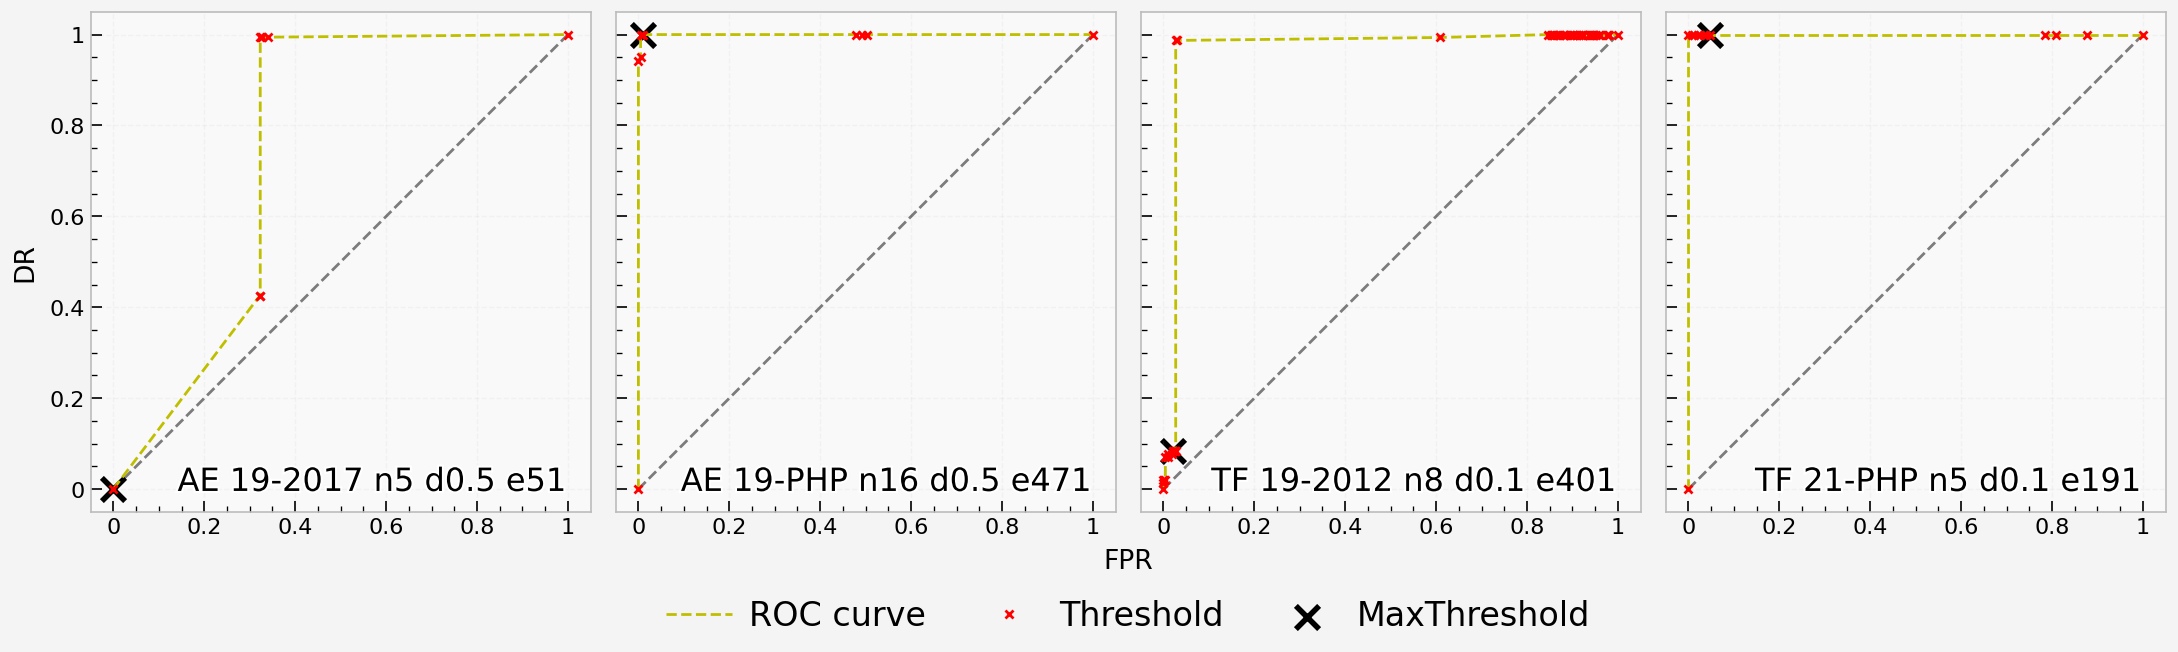

In [16]:

def plot_roc_curves_picked():
    ncols = 4
    nrows = 1
    fig: Figure
    fig, axs = pplt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, refwidth=2.5, refheight=2.5, )
    ax_idx = 0
    for config, epoch in configs.items():
        detected_false_over_epoch = all_detected_false_over_epochs[config]
        idx = (epoch - 1) // 5
        s = detected_false_over_epoch[idx]
        ax: Axes = axs[ax_idx]

        ax.plot([0, 1], [0, 1], "k--", linewidth=1, alpha=0.5)
        ax.set_ylim([-0.05, 1.05])
        ax.set_xlim([-0.05, 1.05])
        lroc = ax.plot(s.fpr, s.tpr, "y--", label=f"ROC curve (area = {s.roc_auc:.2f})", linewidth=1)

        for _tpr, _fpr in zip(s.tpr, s.fpr):
            lft = ax.plot(_fpr, _tpr, "rx", markersize=3)

        ax.set_title(
            f"{config[0]} {dataset_short[config[1]]}-{scenario_short[config[2]]} n{config[3]} d{config[4] if config[0] == 'AE' else config[7]} e{s.epoch} ",
        )

        lmax = ax.scatter(s.fpr_max, s.tpr_max, c='black', marker='x', s=70, label='max threshold')
        ax_idx += 1

    fig.format(
        titleloc="lr",
        fontsize=8,
        xlabel="FPR",
        ylabel="DR",
    )
    with pplt.rc.context({'legend.fontsize': 12}):
        fig.legend(
            handles=[lroc[0], lft[0], lmax],
            labels=["ROC curve", "Threshold", "MaxThreshold"],
            loc="b",
            frame=False,
            fontsize=8,
        )

    path = "final_plots/all_or_none_roc_curves_picked.png"
    fig.save(path, dpi=400)

plt.rcParams.update({"text.usetex": False, })

plot_roc_curves_picked()


In [174]:

configs = [
    # ('AE', 'LID-DS-2019', 'CVE-2017-7529', 5, 0.5, False, True),
    # ('AE', 'LID-DS-2019', 'PHP_CWE-434', 8, 0.5, False, True),
    ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 5, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2019', 'CVE-2012-2122', 5, 16, 2, 2, 0.1, False),
    # ('TF', 'LID-DS-2021', 'CVE-2017-7529', 16, 16, 2, 2, 0.1, False)
]

In [175]:
per_rec_anos = {}

In [176]:
# cache
def cache_fp_wtf_anos():
    for config in configs:
        path = f"final_plots/fp_wtf_anos/{config[0]}_{config[1]}_{config[2]}_{config[3]}_{config[4]}_{config[5]}_{config[6]}_fp_wtf_anos.pkl"
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        if os.path.exists(path):
            print("skip", config)
            continue
        gc.collect()
        anos_s = get_cached_anomaly_scores(config, base_path=BASE_PATH)[796]
        per_rec_anos[config] = anos_s
        with open(path, "wb") as f:
            pickle.dump(anos_s, f)


cache_fp_wtf_anos()

skip ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 5, 16, 2, 2, 0.1, False)
skip ('TF', 'LID-DS-2019', 'CVE-2012-2122', 5, 16, 2, 2, 0.1, False)


In [177]:
for config in configs:
    gc.collect()
    path = f"final_plots/fp_wtf_anos/{config[0]}_{config[1]}_{config[2]}_{config[3]}_{config[4]}_{config[5]}_{config[6]}_fp_wtf_anos.pkl"
    with open(path, "rb") as f:
        per_rec_anos[config] = pickle.load(f)


TF 19-BF 52 AnomalyScores: epoch=796, detected=True, false_positive=True, threshold=3.085519552230835, threshold_train=2.472215175628662, dc=52, fpc=36
TF 19-2012 32 AnomalyScores: epoch=796, detected=True, false_positive=True, threshold=2.378577470779419, threshold_train=2.610093593597412, dc=32, fpc=58


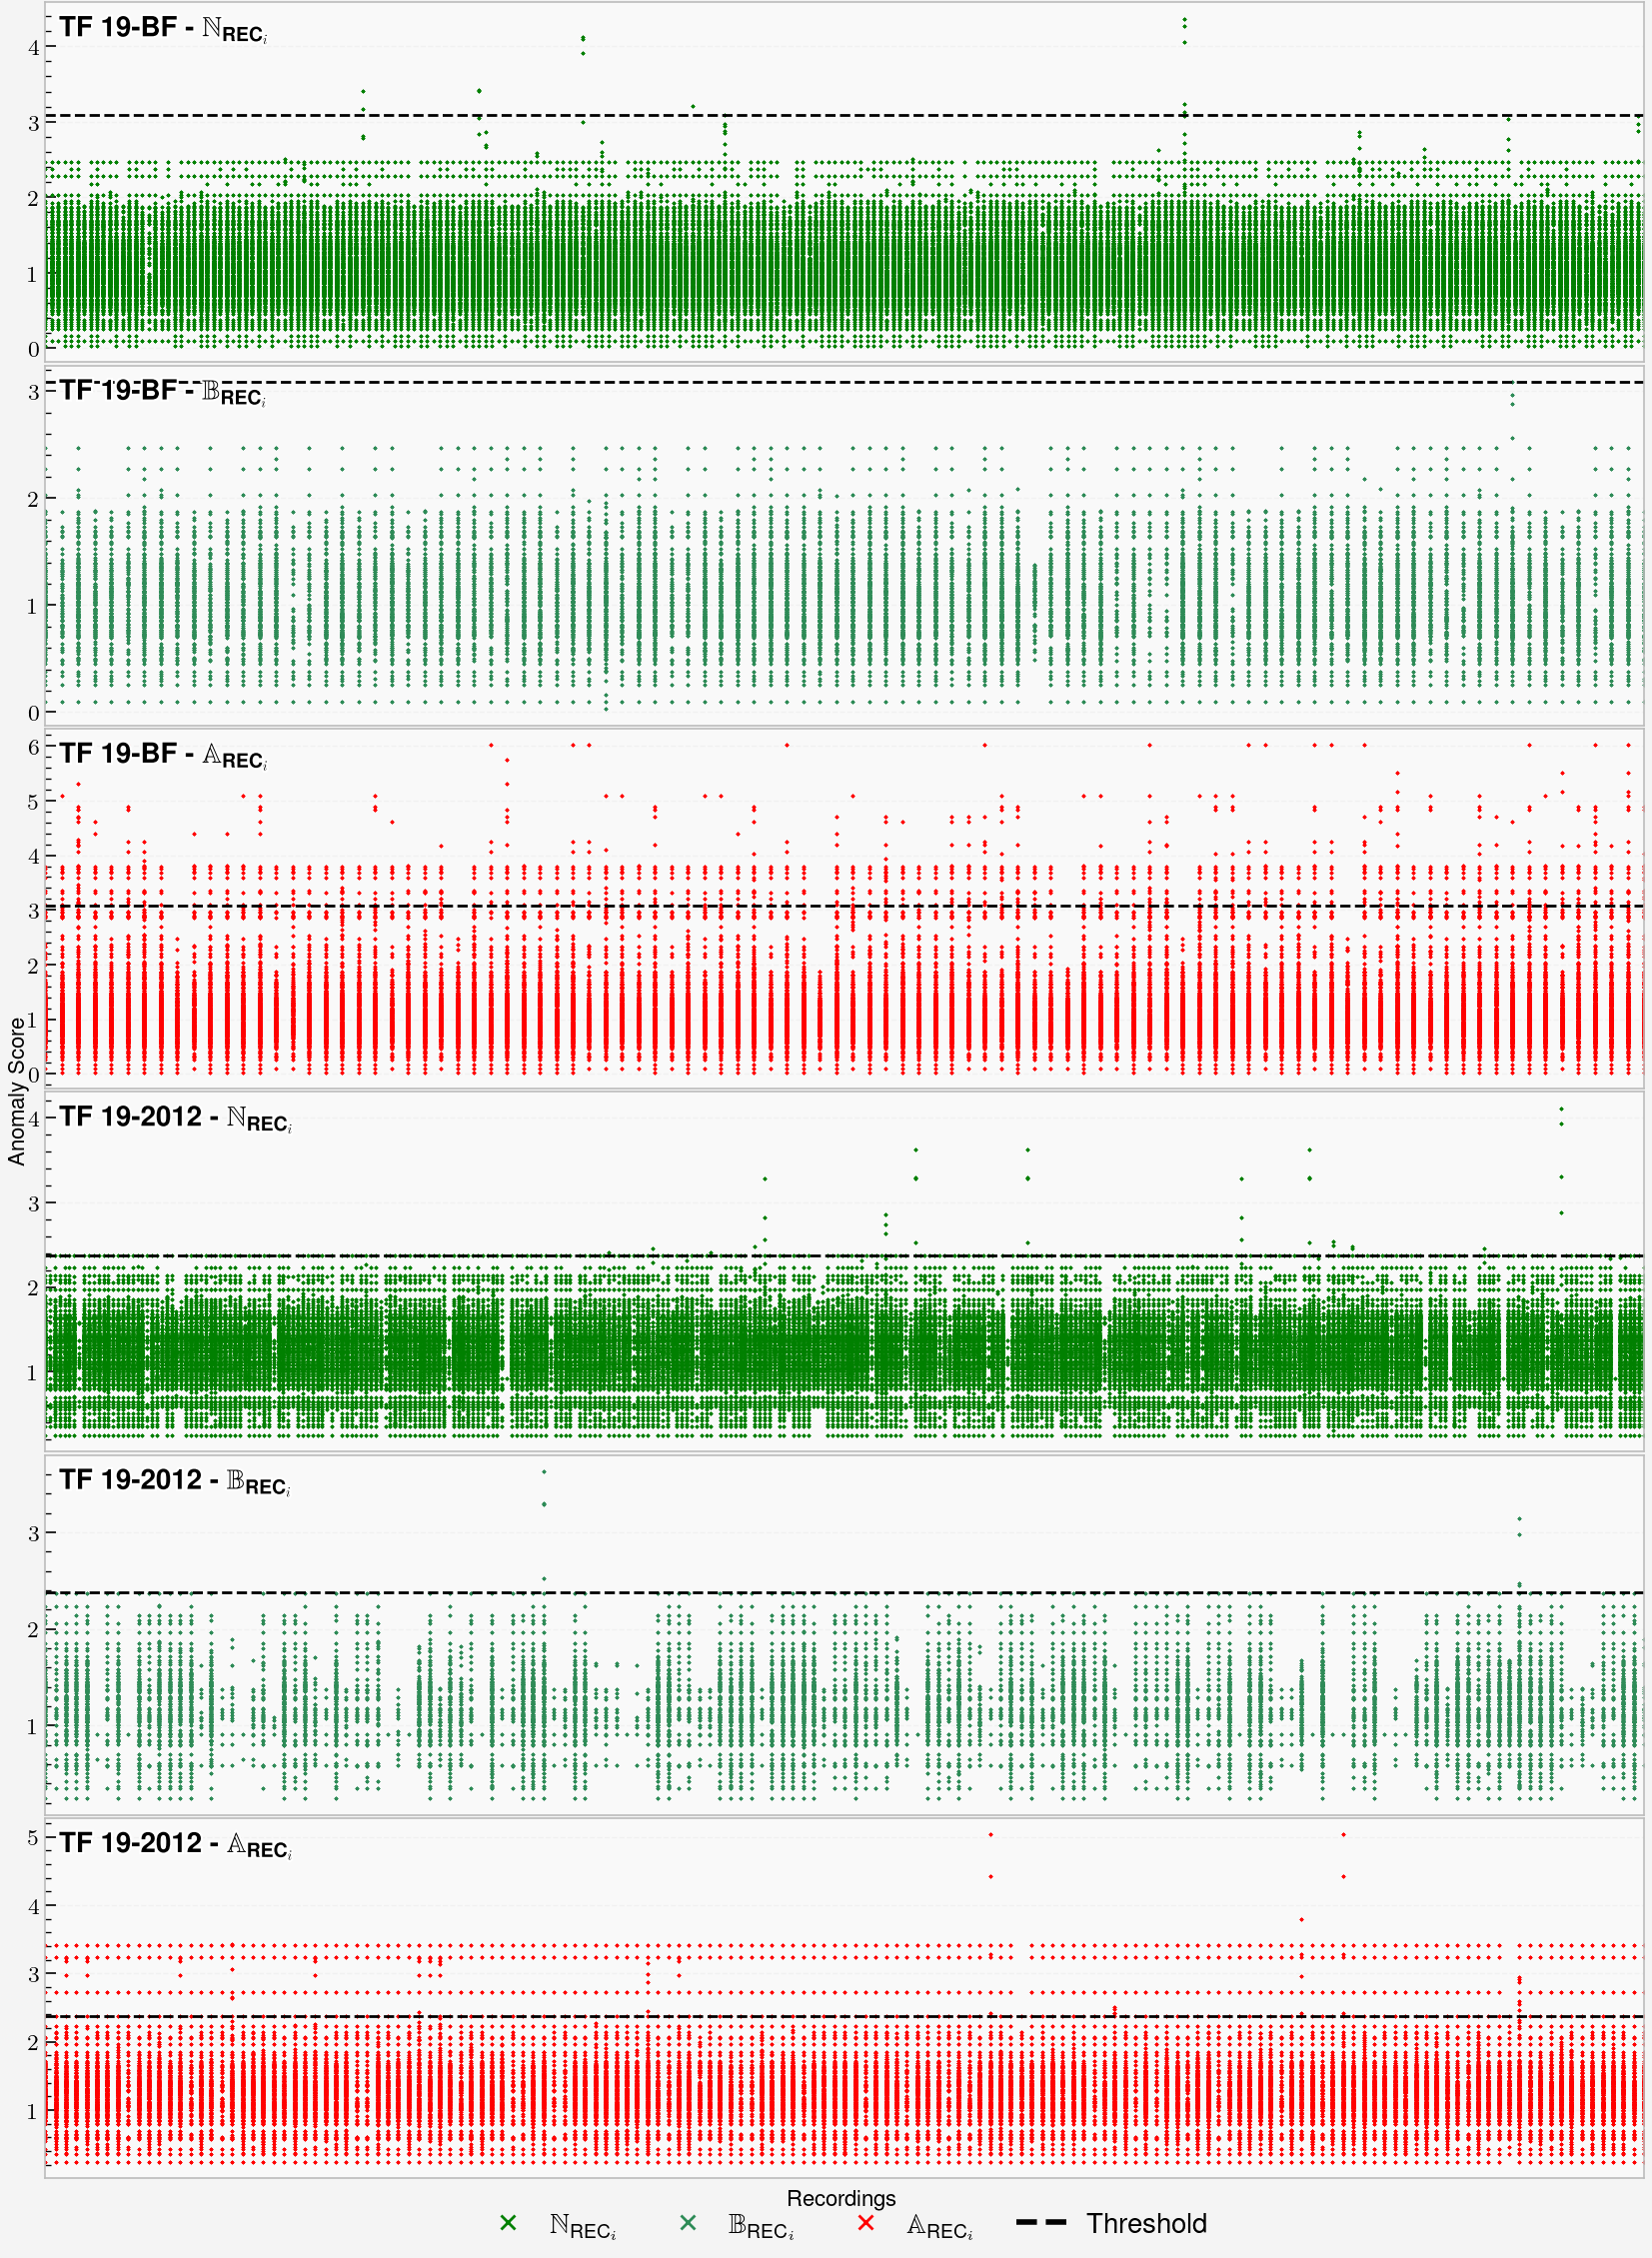

In [178]:
from matplotlib.ticker import MaxNLocator

nrows = len(configs) * 3
fig, axs = pplt.subplots(nrows=nrows, ncols=1, sharex=False, refwidth=8, refheight=1.8, innerpad=0.2, top=0.2)
ax_idx = 0
for config in configs:
    log_scale = True
    marker_size = 0.8
    anos_s: AnomalyScores = per_rec_anos[config]
    title = f"{config[0]} {dataset_short[config[1]]}-{scenario_short[config[2]]}"
    threshold = anos_s.threshold
    print(title, sum(anos_s.detected), anos_s)

    # normal per rec
    ax_d: Axes = axs[ax_idx]
    ax_d.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_d.tick_params(axis='y', labelsize=8)
    ax_d.tick_params(axis='x', labelsize=8)
    ax_idx += 1
    for rec, _anos in enumerate(list(anos_s.normal_per_recording.values())[::3]):
        l1 = ax_d.plot(
            [rec] * len(_anos),
            _anos,
            "x",
            color='green',
            label="normal",
            markersize=marker_size,
        )
    # threshold horizontal line
    ax_d.axhline(y=threshold, color='black', linestyle='--', linewidth=1)
    ax_d.set_title(
        label=r"\textbf{" + title + " - " + ngs["normal_rec"] + "}",
        fontdict={"fontsize": 10, "fontweight": "bold"},
    )

    # before per rec
    ax_d = axs[ax_idx]
    ax_d.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_d.tick_params(axis='y', labelsize=8)
    ax_d.tick_params(axis='x', labelsize=8)
    ax_idx += 1
    for rec, _anos in enumerate(anos_s.before_exploit_per_recording.values()):
        l2 = ax_d.plot(
            [rec] * len(_anos),
            _anos,
            "x",
            color='seagreen',
            label="before",
            markersize=marker_size,
        )
    ax_d.axhline(y=threshold, color='black', linestyle='--', linewidth=1)
    ax_d.set_title(
        label=r"\textbf{" + title + " - " + ngs["before_rec"] + "}",
        fontdict={"fontsize": 10, "fontweight": "bold"},
    )

    # after per rec
    ax_d = axs[ax_idx]
    ax_d.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_d.tick_params(axis='y', labelsize=8)
    ax_d.tick_params(axis='x', labelsize=8)
    ax_idx += 1
    for rec, _anos in enumerate(anos_s.after_exploit_per_recording.values()):
        l3 = ax_d.plot(
            [rec] * len(_anos),
            _anos,
            "x",
            color='red',
            label="after",
            markersize=marker_size,
        )
    l4 = ax_d.axhline(y=threshold, color='black', linestyle='--', linewidth=1)
    ax_d.set_title(
        label=r"\textbf{" + title + " - " + ngs["after_rec"] + "}",
        fontdict={"fontsize": 10, "fontweight": "bold"},
    )

axs.format(
    ylabel="Anomaly Score",
    ylabelpad=-0.5,
    labelsize=8,
    titleloc="ul",
    xtickminor=False,
    xticks=[]
)

axs[-1:].format(
    xlabel="Recordings",
)

with pplt.rc.context({'legend.fontsize': 10}):
    fig.legend(
        [l1[0], l2[0], l3[0], l4],
        [ngs["normal_rec"], ngs["before_rec"], ngs["after_rec"], "Threshold"],
        loc="b",
        frame=False,
        fontsize=6,
        ncol=4,
        markersize=5,
        linewidth=2,
        pad=0,
    )

path = "final_plots/all_or_none_anomaly_scores_per_recording.png"
fig.save(path, dpi=400)

In [72]:
configs = [
    ('AE', 'LID-DS-2019', 'CVE-2017-7529', 5, 0.5, False, True),
    ('AE', 'LID-DS-2019', 'CVE-2012-2122', 5, 0.5, False, True),
    ('AE', 'LID-DS-2019', 'PHP_CWE-434', 16, 0.5, False, True),
    ('AE', 'LID-DS-2019', 'SQL_Injection_CWE-89', 5, 0.5, False, True),
    ('AE', 'LID-DS-2019', 'CVE-2019-5418', 8, 0.5, False, True),
    ('AE', 'LID-DS-2021', 'PHP_CWE-434', 5, 0.5, False, True),
    ('TF', 'LID-DS-2019', 'CVE-2017-7529', 8, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2019', 'CVE-2012-2122', 8, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2019', 'CVE-2012-2122', 5, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2021', 'CVE-2012-2122', 5, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2019', 'Bruteforce_CWE-307', 16, 16, 2, 2, 0.1, False),
    ('TF', 'LID-DS-2021', 'PHP_CWE-434', 5, 16, 2, 2, 0.1, False),
]

In [99]:
scenarios = [
    "CVE-2017-7529",
    "CVE-2014-0160",
    "CVE-2012-2122",
    "Bruteforce_CWE-307",
    # "CWE-89-SQL-injection",
    "SQL_Injection_CWE-89",
    "PHP_CWE-434",
    # "CVE-2019-5418",
    # "CVE-2018-3760",
]



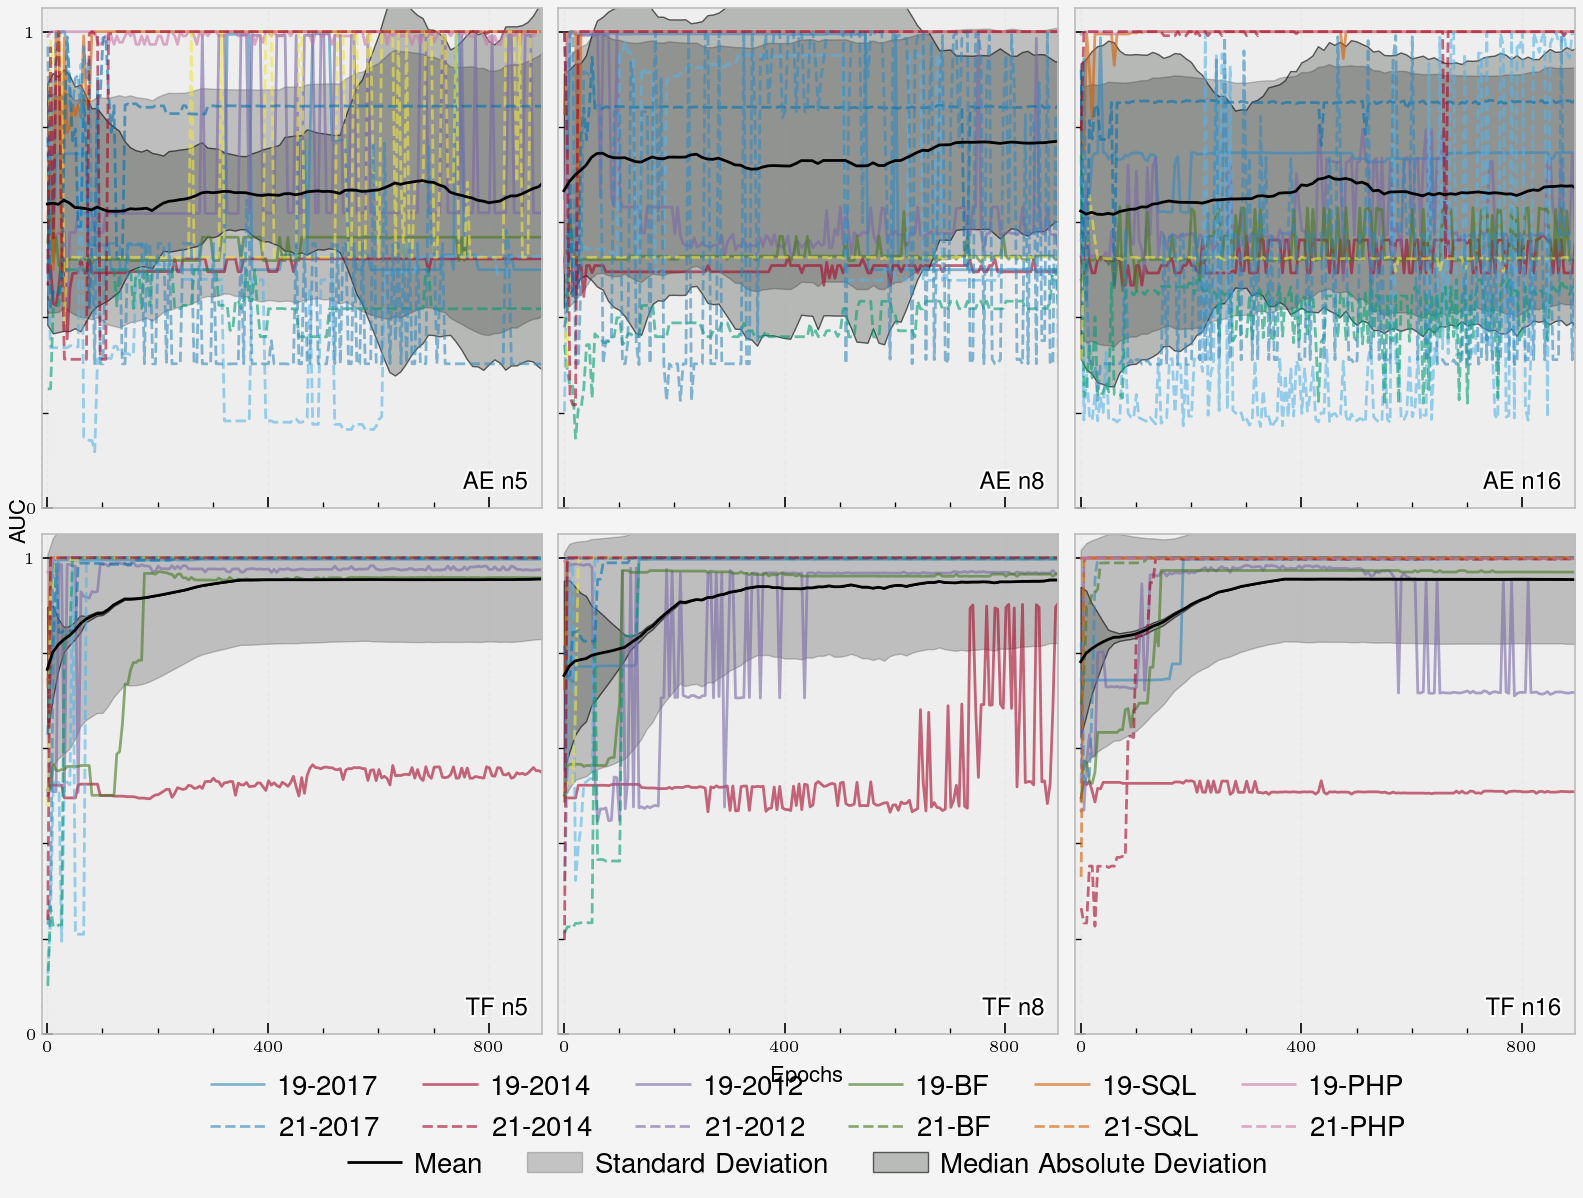

In [102]:
def plot_auc_over_epoch():
    ncols = 3
    nrows = 2
    fig, axs = pplt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, refwidth=2.5, refheight=2.5, )
    ax_idx = 0
    for algo in ['AE', 'TF']:
        for ngram_len in [5, 8, 16]:
            ax: Axes
            ax = axs[ax_idx]
            title = f"{algo} n{ngram_len}"
            ax.set_title(title)
            lns = []
            labels = []
            all_aucs = []
            for dataset in ['LID-DS-2019', 'LID-DS-2021']:
                plt.gca().set_prop_cycle("bmh")
                for scenario in scenarios:
                    if dataset == 'LID-DS-2021' and scenario == 'SQL_Injection_CWE-89':
                        scenario = 'CWE-89-SQL-injection'
                    if algo == 'AE':
                        config = ('AE', dataset, scenario, ngram_len, 0.5, False, True)
                    else:
                        config = ('TF', dataset, scenario, ngram_len, 16, 2, 2, 0.1, False)
                    detected_false_over_epochs = get_detected_false_coutes(config)
                    epochs = [_anos.epoch for _anos in detected_false_over_epochs]
                    aucs = [_anos.roc_auc for _anos in detected_false_over_epochs]
                    all_aucs.append(aucs)
                    ln = ax.plot(
                        epochs,
                        aucs,
                        linewidth=1,
                        markeredgewidth=1,
                        linestyle='--' if dataset == 'LID-DS-2021' else '-',
                        alpha=0.6,
                    )
                    lns.append(ln[0])
                    labels.append(f"{dataset_short[dataset]}-{scenario_short[scenario]}")
                    ax.set_ylim([0, 1.05])
                    ax.set_xlim([-10, max(epochs)])
                    ax.set_yticks([0, 1])
                    ax.set_xticks(range(0, max(epochs) + 1, 400))
            all_aucs = np.array(all_aucs, dtype=np.float64)
            mean_aucs = np.mean(all_aucs, axis=0)
            std_aucs = np.std(all_aucs, axis=0)
            median_aucs = np.median(all_aucs, axis=0)
            mad_aucs = np.median(np.abs(all_aucs - median_aucs), axis=0) * 1.4826  # Scaling factor for MAD

            # Smooth mean and MAD
            smoothing = 10
            mean_aucs = np.convolve(mean_aucs, np.ones(smoothing), 'valid') / smoothing
            mad_aucs = np.convolve(mad_aucs, np.ones(smoothing), 'valid') / smoothing
            std_aucs = np.convolve(std_aucs, np.ones(smoothing), 'valid') / smoothing
            epochs = np.arange(0, len(mean_aucs)) * smoothing

            ln_mean = ax.plot(
                epochs,
                mean_aucs,
                linewidth=1,
                markeredgewidth=1,
                linestyle='-',
                alpha=1,
                color='black',
                label='Mean',
            )

            ln_mad = ax.fill_between(
                epochs,
                mean_aucs - mad_aucs,
                mean_aucs + mad_aucs,
                alpha=0.6,
                color='grey',
                label='MAD',
                edgecolor='black',
            )

            ln_std = ax.fill_between(
                epochs,
                mean_aucs - std_aucs,
                mean_aucs + std_aucs,
                alpha=0.2,
                color='black',
                label='STD',
            )
            lns.append(ln_mean[0])
            lns.append(ln_std)
            lns.append(ln_mad)

            labels.append("Mean")
            labels.append("Standard Deviation")
            labels.append("Median Absolute Deviation")

            ax_idx += 1

    fig.format(
        xlabel="Epochs",
        ylabel="AUC",
        labelsize=8,
        titleloc="lr",
        ylabelpad=-1,
    )
    # center legend

    with pplt.rc.context({'legend.fontsize': 10}):
        fig.legend(
            handles=lns[:-3],
            labels=labels[:-3],
            loc="b",
            frame=False,
            fontsize=6,
            ncol=len(scenarios),
        )

        fig.legend(
            handles=lns[-3:],
            labels=labels[-3:],
            loc="b",
            frame=False,
            fontsize=6,
            ncol=3,
        )

    path = "final_plots/all_or_none_auc_over_epochs.png"
    fig.save(path, dpi=400)


plot_auc_over_epoch()


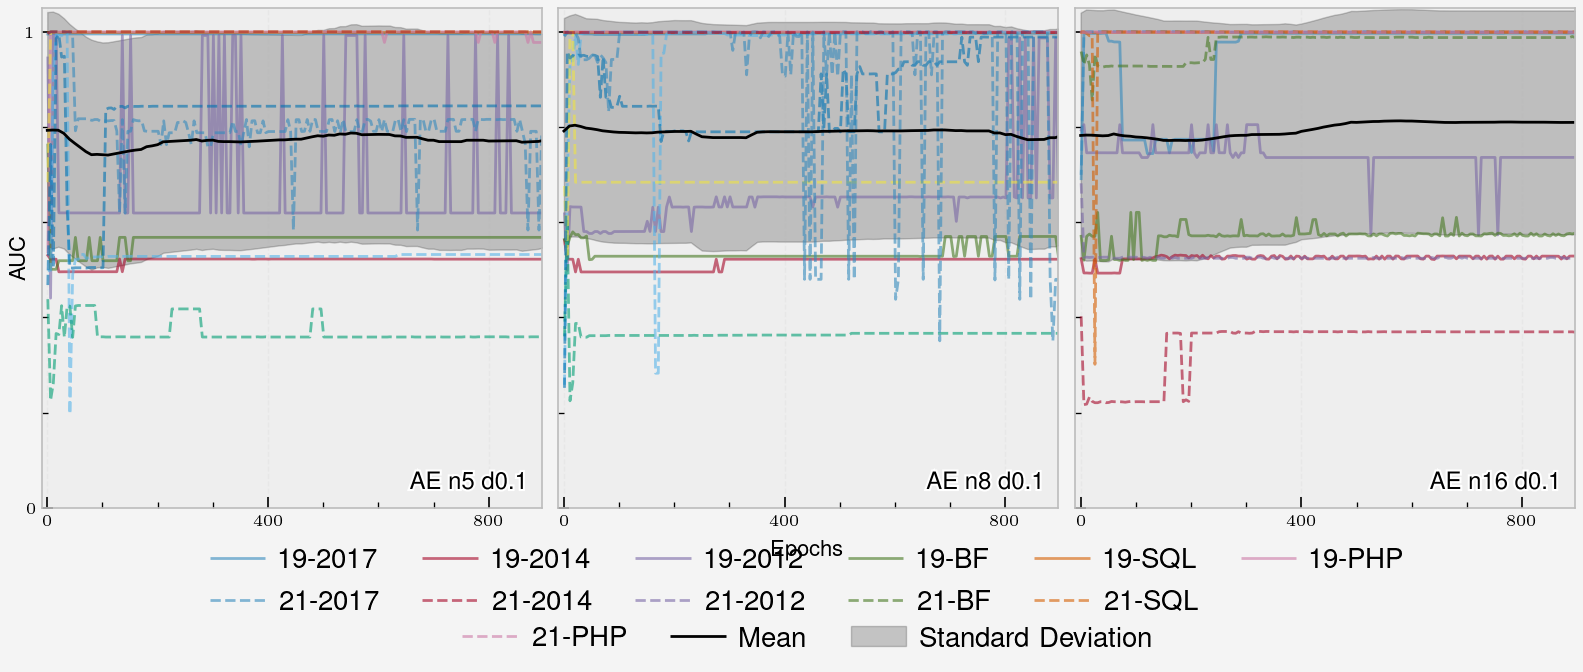

In [101]:
def plot_auc_over_epoch_ae_dropout():
    ncols = 3
    nrows = 1
    fig, axs = pplt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, refwidth=2.5, refheight=2.5, )
    marker_size = 1
    ax_idx = 0
    for dropout in [0.1]:
        for ngram_len in [5, 8, 16]:
            ax: Axes
            ax = axs[ax_idx]
            title = f"AE n{ngram_len} d{dropout}"
            ax.set_title(title)
            lns = []
            labels = []
            all_aucs = []
            for dataset in ['LID-DS-2019', 'LID-DS-2021']:
                plt.gca().set_prop_cycle("bmh")
                for scenario in scenarios:
                    if dataset == 'LID-DS-2021' and scenario == 'SQL_Injection_CWE-89':
                        scenario = 'CWE-89-SQL-injection'
                    config = ('AE', dataset, scenario, ngram_len, dropout, False, True)
                    detected_false_over_epochs = get_detected_false_coutes(config)
                    epochs = [_anos.epoch for _anos in detected_false_over_epochs]
                    aucs = [_anos.roc_auc for _anos in detected_false_over_epochs]
                    all_aucs.append(aucs)
                    ln = ax.plot(
                        epochs,
                        aucs,
                        linewidth=1,
                        markeredgewidth=1,
                        linestyle='--' if dataset == 'LID-DS-2021' else '-',
                        alpha=0.6,
                    )
                    lns.append(ln[0])
                    labels.append(
                        "19-" + scenario_short[scenario] if dataset == 'LID-DS-2019' else "21-" + scenario_short[
                            scenario]
                    )
                    ax.set_ylim([0, 1.05])
                    ax.set_xlim([-10, max(epochs)])
                    ax.set_yticks([0, 1])
                    ax.set_xticks(range(0, max(epochs) + 1, 400))
            all_aucs = np.array(all_aucs)
            mean_aucs = np.mean(all_aucs, axis=0)
            std_aucs = np.std(all_aucs, axis=0)
            median_aucs = np.median(all_aucs, axis=0)
            mad_aucs = np.median(np.abs(all_aucs - median_aucs), axis=0) * 1.4826  # Scaling factor for MAD

            # Smooth mean and MAD
            smoothing = 10
            mean_aucs = np.convolve(mean_aucs, np.ones(smoothing), 'valid') / smoothing
            mad_aucs = np.convolve(mad_aucs, np.ones(smoothing), 'valid') / smoothing
            std_aucs = np.convolve(std_aucs, np.ones(smoothing), 'valid') / smoothing
            epochs = np.arange(0, len(mean_aucs)) * smoothing

            ln_mean = ax.plot(
                epochs,
                mean_aucs,
                linewidth=1,
                markeredgewidth=1,
                linestyle='-',
                alpha=1,
                color='black',
                label='Mean',
            )

            ln_mad = ax.fill_between(
                epochs,
                mean_aucs - mad_aucs,
                mean_aucs + mad_aucs,
                alpha=0.6,
                color='grey',
                label='Median Absolute Deviation',
                edgecolor='black',
            )

            ln_std = ax.fill_between(
                epochs,
                mean_aucs - std_aucs,
                mean_aucs + std_aucs,
                alpha=0.2,
                color='black',
                label='Standard Deviation'
            )
            lns.append(ln_mean[0])
            lns.append(ln_std)
            lns.append(ln_mad)

            labels.append("Mean")
            labels.append("Standard Deviation")
            labels.append("Median Absolute Deviation")
            ax_idx += 1

    fig.format(
        xlabel="Epochs",
        ylabel="AUC",
        labelsize=8,
        titleloc="lr",
        ylabelpad=-1,
    )
    # center legend
    with pplt.rc.context({'legend.fontsize': 10}):
        fig.legend(
            handles=lns[:-3],
            labels=labels[:-3],
            loc="b",
            frame=False,
            fontsize=6,
            ncol=len(scenarios),
        )

        fig.legend(
            handles=lns[-3:],
            labels=labels[-3:],
            loc="b",
            frame=False,
            fontsize=6,
            ncol=3,
        )

    path = "final_plots/all_or_none_auc_over_epochs_ae_dropout.png"
    fig.save(path, dpi=400)


plot_auc_over_epoch_ae_dropout()


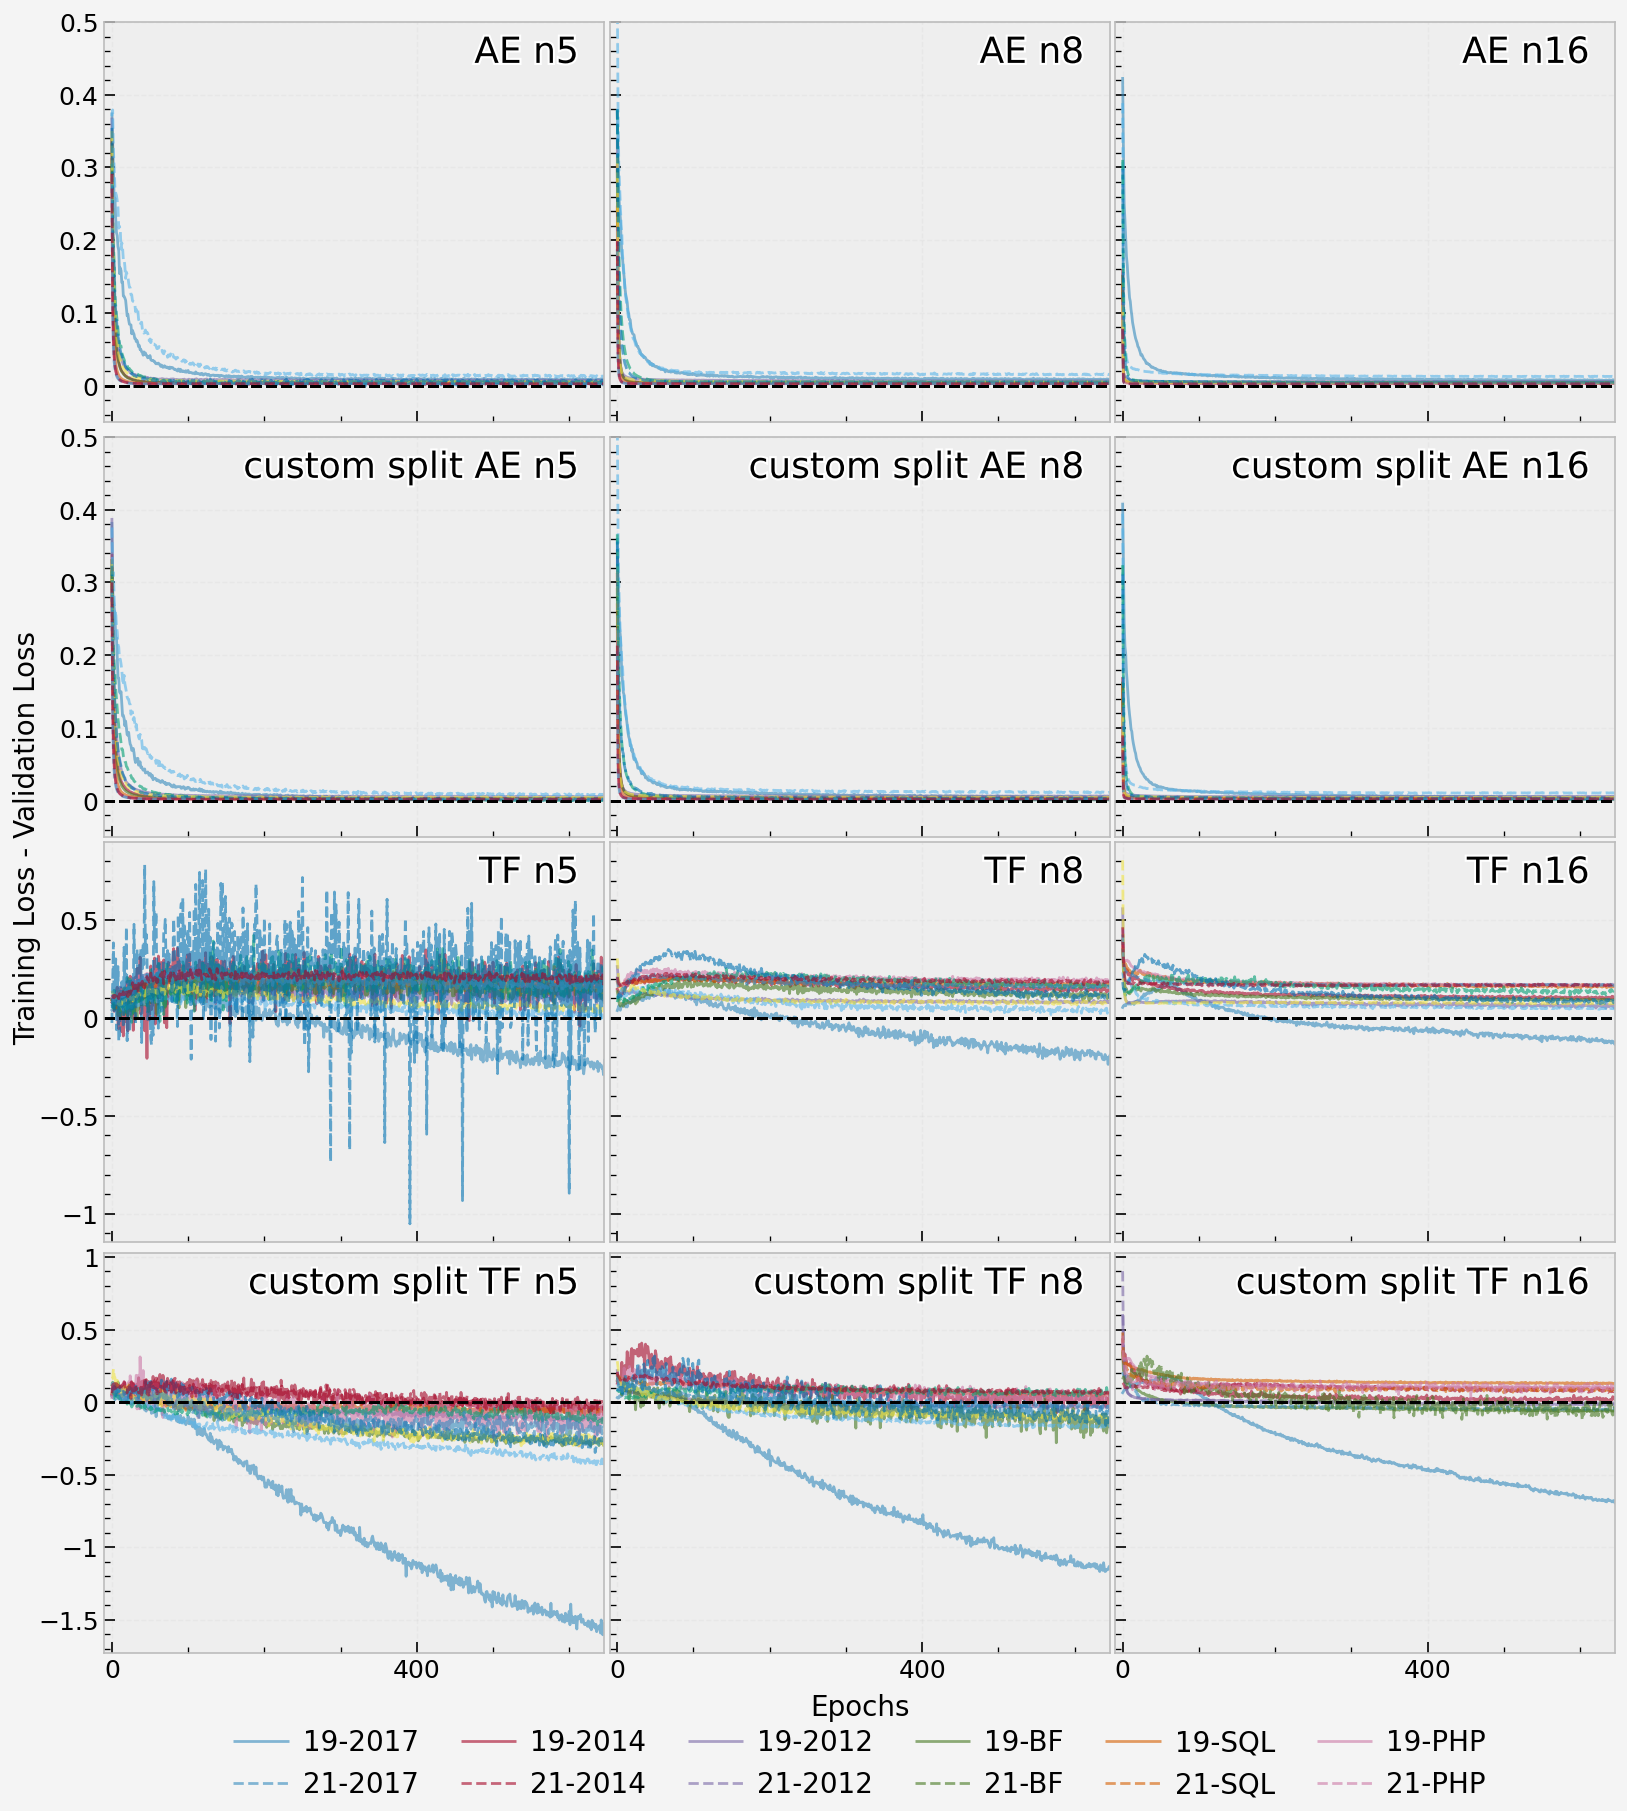

In [83]:

def plot_losses_over_epoch():
    ncols = 3
    nrows = 4
    fig, axs = pplt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, refwidth=2.5, refheight=2.0, innerpad=0.2)
    marker_size = 1
    ax_idx = 0
    for algo in ['AE', 'TF']:
        for split in [False, True]:
            for ngram_len in [5, 8, 16]:
                ax: Axes
                ax = axs[ax_idx]
                title = f"{'custom split' if split else ''} {algo} n{ngram_len} "
                ax.set_title(title)
                lns = []
                labels = []
                for dataset in ['LID-DS-2019', 'LID-DS-2021']:
                    plt.gca().set_prop_cycle("bmh")
                    for scenario in scenarios:
                        if dataset == 'LID-DS-2021' and scenario == 'SQL_Injection_CWE-89':
                            scenario = 'CWE-89-SQL-injection'
                        if algo == 'AE':
                            config = ('AE', dataset, scenario, ngram_len, 0.1, split, True)
                        else:
                            config = ('TF', dataset, scenario, ngram_len, 16, 2, 2, 0.1, split)

                        train_losses, val_losses = get_cached_losses(config, base_path=BASE_PATH)
                        train_losses = list(train_losses.values())
                        val_losses = list(val_losses.values())
                        train_loss_minus_val_loss = [train_loss - val_loss for train_loss, val_loss in
                                                     zip(train_losses, val_losses)]

                        ln3 = ax.plot(
                            train_loss_minus_val_loss,
                            linewidth=1,
                            markeredgewidth=1,
                            linestyle='-' if dataset == 'LID-DS-2019' else '--',
                            alpha=0.6,
                        )
                        lns.append(ln3[0])
                        labels.append(f"{dataset_short[dataset]}-{scenario_short[scenario]}")
                        # ax.set_ylim([0, 1.05])
                        ax.set_xlim([-10, max(epochs)])
                        if algo == 'AE':
                            ax.set_ylim([-0.05, .5])
                        ax.set_xticks(range(0, max(epochs) + 1, 400))
                        ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
                ax_idx += 1

    fig.format(
        xlabel="Epochs",
        ylabel="Training Loss - Validation Loss",
        labelsize=10,
        titleloc="ur",
        ylabelpad=-1,
    )

    with pplt.rc.context({'legend.fontsize': 10}):
        fig.legend(
            # handles=[ln1[0], ln2[0]],
            handles=lns,
            labels=labels,
            loc="b",
            frame=False,
            fontsize=16,
            ncol=len(labels) // 2,
        )

    path = f"final_plots/all_or_none_losses_over_epochs.png"
    fig.save(path, dpi=400)


plot_losses_over_epoch()

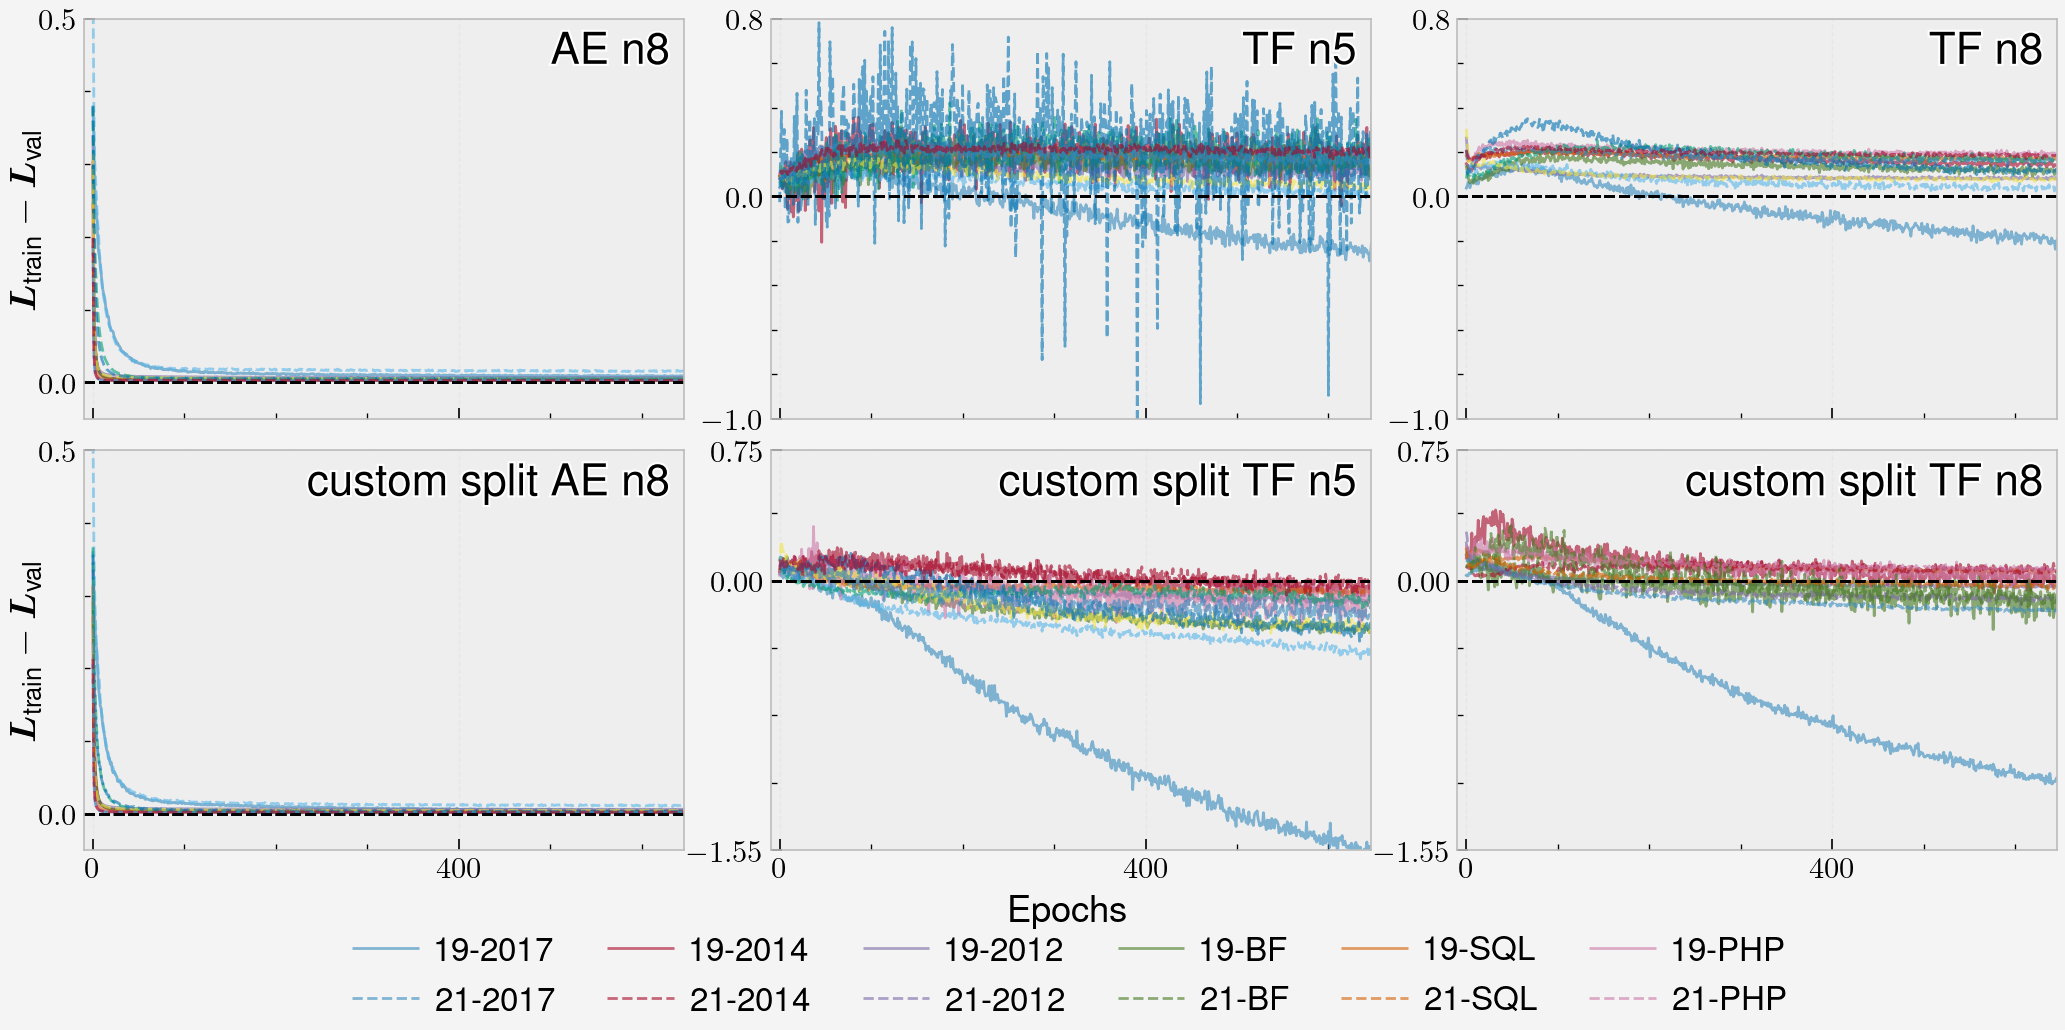

In [98]:
def plot_losses_over_epoch_2():
    ncols = 3
    nrows = 2
    fig, axs = pplt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, refwidth=3, refheight=2.0, innerpad=0.2)
    marker_size = 1
    ax_idx = 0
    for split in [False, True]:
        # for algo, ngram_len in [('AE', 8), ('TF', 5), ('TF', 8),  ('TF', 16)]:
        for algo, ngram_len in [('AE', 8), ('TF', 5), ('TF', 8)]:
            ax: Axes
            ax = axs[ax_idx]
            title = f"{'custom split' if split else ''} {algo} n{ngram_len} "
            ax.set_title(title)
            lns = []
            labels = []
            for dataset in ['LID-DS-2019', 'LID-DS-2021']:
                plt.gca().set_prop_cycle("bmh")
                for scenario in scenarios:
                    if dataset == 'LID-DS-2021' and scenario == 'SQL_Injection_CWE-89':
                        scenario = 'CWE-89-SQL-injection'
                    if algo == 'AE':
                        config = ('AE', dataset, scenario, ngram_len, 0.1, split, True)
                    else:
                        config = ('TF', dataset, scenario, ngram_len, 16, 2, 2, 0.1, split)

                    train_losses, val_losses = get_cached_losses(config, base_path=BASE_PATH)
                    train_losses = list(train_losses.values())
                    val_losses = list(val_losses.values())
                    train_loss_minus_val_loss = [train_loss - val_loss for train_loss, val_loss in
                                                 zip(train_losses, val_losses)]

                    ln3 = ax.plot(
                        train_loss_minus_val_loss,
                        linewidth=1,
                        markeredgewidth=1,
                        linestyle='-' if dataset == 'LID-DS-2019' else '--',
                        alpha=0.6,
                    )
                    lns.append(ln3[0])
                    labels.append(f"{dataset_short[dataset]}-{scenario_short[scenario]}")
                    # ax.set_ylim([0, 1.05])
                    ax.set_xlim([-10, max(epochs)])
                    if algo == 'AE':
                        ax.set_ylim([-0.05, .5])
                        ax.set_yticks([0, 0.5])
                    if algo == 'TF':
                        if split:
                            ax.set_ylim([-1.55, 0.75])
                            ax.set_yticks([-1.55,0, 0.75])
                        else:
                            ax.set_ylim([-1, 0.8])
                            ax.set_yticks([-1, 0, 0.8])
                    ax.set_xticks(range(0, max(epochs) + 1, 400))
                    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
            ax_idx += 1
    
    axs[:,0].format(
        ylabel=r"$\bm{L}_{\text{train}} - \bm{L}_{\text{val}}$",
        labelsize=11,
        titleloc="ur",
        ylabelpad=-1,
    )

    axs.format(
        xlabel="Epochs",
        fontsize=11,
        titleloc="ur",
    )
    with pplt.rc.context({'legend.fontsize': 12}):
        fig.legend(
            handles=lns,
            labels=labels,
            loc="b",
            frame=False,
            fontsize=18,
            pad=3,
            ncol=len(labels) // 2,
        )

    path = f"final_plots/all_or_none_losses_over_epochs_2.png"
    fig.save(path, dpi=400)


plt.rcParams.update(
    {
        "text.usetex": True,
        'text.latex.preamble': r'\usepackage{amsfonts,amsmath,bm}',
        "font.family": "sans-serif",
    }
)

plot_losses_over_epoch_2()
